In [94]:
import os
import sys
import torch
from visual import *
import thinker.util as util
import matplotlib.pyplot as plt
from argparse import Namespace
import json
import csv
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as mtick


class RetBuffer:
    def __init__(self, max_actor_id, mean_n=400):
        """
        Compute the trailing mean return by storing the last return for each actor
        and average them;
        Args:
            max_actor_id (int): maximum actor id
            mean_n (int): size of data for computing mean
        """
        buffer_n = mean_n // max_actor_id + 1
        self.return_buffer = np.zeros((max_actor_id, buffer_n))
        self.return_buffer_pointer = np.zeros(
            max_actor_id, dtype=int
        )  # store the current pointer
        self.return_buffer_n = np.zeros(
            max_actor_id, dtype=int
        )  # store the processed data size
        self.max_actor_id = max_actor_id
        self.mean_n = mean_n
        self.all_filled = False

    def insert(self, returns, actor_ids):
        """
        Insert new returnss to the return buffer
        Args:
            returns (tuple): tuple of float, the return of each ended episode
            actor_ids (tuple): tuple of int, the actor id of the corresponding ended episode
        """
        # actor_id is a tuple of integer, corresponding to the returns
        if len(returns) == 0:
            return
        assert len(returns) == len(actor_ids)
        for r, actor_id in zip(returns, actor_ids):
            # Find the current pointer for the actor
            if actor_id >= self.max_actor_id:
                continue
            pointer = self.return_buffer_pointer[actor_id]
            # Update the return buffer for the actor with the new return
            self.return_buffer[actor_id, pointer] = r
            # Update the pointer for the actor
            self.return_buffer_pointer[actor_id] = (
                pointer + 1
            ) % self.return_buffer.shape[1]
            # Update the processed data size for the actor
            self.return_buffer_n[actor_id] = min(
                self.return_buffer_n[actor_id] + 1, self.return_buffer.shape[1]
            )

        if not self.all_filled:
            # check if all filled
            self.all_filled = np.all(
                self.return_buffer_n >= self.return_buffer.shape[1]
            )

    def insert_raw(self, episode_returns, ind, actor_id, done):
        episode_returns = episode_returns[done][:, ind]
        episode_returns = tuple(episode_returns.detach().cpu().numpy())
        done_ids = actor_id.broadcast_to(done.shape)[done]
        done_ids = tuple(done_ids.detach().cpu().numpy())
        self.insert(episode_returns, done_ids)

    def get_mean(self):
        """
        Compute the mean of the returns in the buffer;
        """
        if self.all_filled:
            overall_mean = np.mean(self.return_buffer)
        else:
            # Create a mask of filled items in the return buffer
            col_indices = np.arange(self.return_buffer.shape[1])
            # Create a mask of filled items in the return buffer
            filled_mask = (
                col_indices[np.newaxis, :] < self.return_buffer_n[:, np.newaxis]
            )
            if np.any(filled_mask):
                # Compute the sum of returns for each actor considering only filled items
                sum_returns = np.sum(self.return_buffer * filled_mask)
                # Compute the mean for each actor by dividing the sum by the processed data size
                overall_mean = sum_returns / np.sum(filled_mask.astype(float))
            else:
                overall_mean = 0.0
        return overall_mean


def plot(
    xs,
    ys,
    labels,
    size=1,
    xlabel="Frames",
    ylabel="Solving Rate",
    saveimg="",
    nolegend=False,
    linestyle="",
    color_orders=None,
    per=True,
    noxtick=False,
    title=None,
    ax=None,
):
    if ax is None:
        plt.figure(figsize=(5 * size, 3.5 * size), dpi=80)
        ax = plt.gca()
    cmap = plt.get_cmap("tab10")
    for n, label in enumerate(labels):
        y = np.array(ys[n])
        if per:
            y = y * 100
        mean = np.mean(y, axis=0)
        std = np.std(y, axis=0)
        if color_orders is None:
            c = cmap(n)
        else:
            c = cmap(color_orders[n])
        ax.plot(xs[n], mean, linestyle, label=label, color=c)
        c = tuple(i * 0.3 + 0.7 for i in c)
        ax.fill_between(xs[n], mean - std, mean + std, label=None, color=c)
    if not nolegend:
        ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if per:
        fmt = "%.0f%%"
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    else:
        ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
    if noxtick:
        ax.set_xticklabels([])
    plt.tight_layout()
    if saveimg:
        plt.savefig(saveimg, dpi=300, bbox_inches="tight")
    if title is not None:
        ax.set_title(title)
    return ax


def read_run(path, run, mean_n=200, log_freq=250000, tran=False):
    path = os.path.join(path, run)
    with open(os.path.join(path, "meta.json"), "r") as f:
        flags = Namespace(**json.load(f)["args"])
    max_actor_id = (
        flags.gpu_num_actors * flags.gpu_num_p_actors
        + flags.cpu_num_actors * flags.cpu_num_p_actors
    )
    print("Reading %s max_actor_id %d" % (run, max_actor_id))
    ret_buffer = RetBuffer(max_actor_id, mean_n)
    csv_file = os.path.join(path, "logs.csv")
    step = log_freq
    steps, returns = [], []
    with open(csv_file, newline="") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            done_ids = eval(row["done_ids"])
            episode_returns = eval(row["episode_returns"])
            if tran:
                episode_returns = tuple(float(r > 10) for r in episode_returns)
            ret_buffer.insert(episode_returns, done_ids)
            if eval(row["real_step"]) >= step:
                steps.append(step)
                returns.append(ret_buffer.get_mean())
                step += log_freq
    return steps, returns

In [11]:
video_stat_path = "C:/Users/chung/Personal/RS/thinker/test/v13_0.7b6-49974528-24"
video_stat = np.load(
    os.path.join(video_stat_path, "video_stat.npy"), allow_pickle=True
).item()
length = len(video_stat["status"])
status = np.copy(video_stat["status"])
for i in range(length):
    if status[i] in [1, 3] and i < length - 1:
        reset_imgs = (
            np.copy(video_stat["real_imgs"][i]),
            np.copy(video_stat["im_imgs"][i]),
            video_stat["status"][i],
        )
        end_imgs = (
            np.copy(video_stat["real_imgs"][i + 1]),
            np.copy(video_stat["im_imgs"][i + 1]),
            video_stat["status"][i + 1],
        )
        (
            video_stat["real_imgs"][i],
            video_stat["im_imgs"][i],
            video_stat["status"][i],
        ) = end_imgs
        (
            video_stat["real_imgs"][i + 1],
            video_stat["im_imgs"][i + 1],
            video_stat["status"][i + 1],
        ) = reset_imgs
gen_video(video_stat, "")

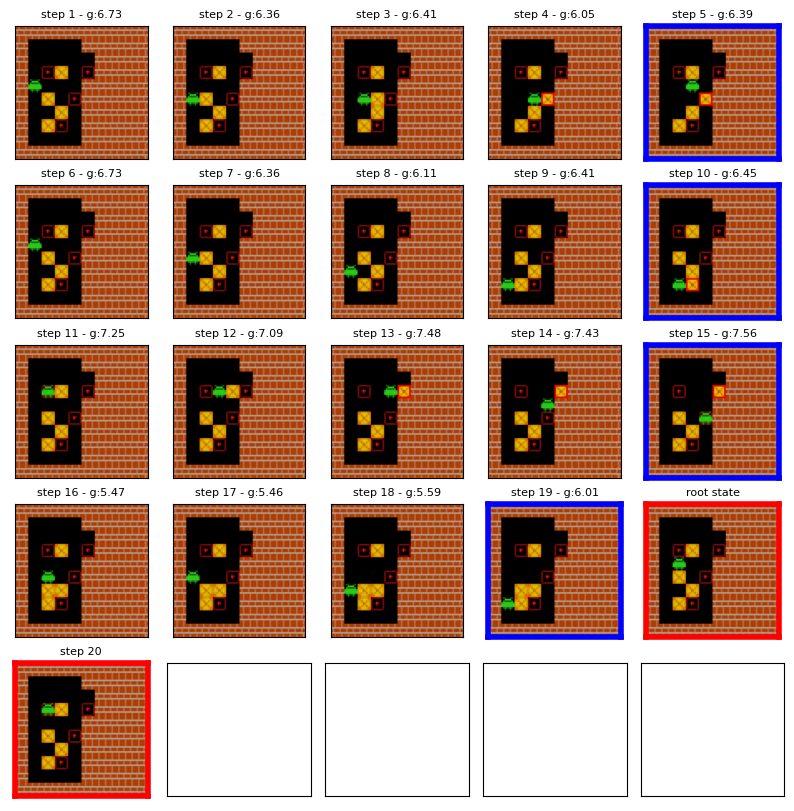

In [14]:
# Visualizaiton of learned planning

video_stat_path = "C:/Users/chung/Personal/RS/thinker/test/v13_0.7b6-49974528-24"
video_stat = np.load(
    os.path.join(video_stat_path, "video_stat.npy"), allow_pickle=True
).item()

k = 0
tot_step = 1
imgs, titles, leaves = [], [], []
rollout_n, rollout_i, cur_k, idx = 1, 1, -1, 0
inc = False
while True:
    status = video_stat["status"][idx]
    if status == 0:
        cur_k += 1
    if cur_k >= k:
        if status == 0:
            # print("add image; status: %d" % status)
            imgs.append(video_stat["real_imgs"][idx])
            titles.append("root state")
            leaves.append(False)
        elif status in [1, 3]:
            inc = True
        elif status == 2:
            # print("add image; status: %d" % status)
            imgs.append(video_stat["im_imgs"][idx])
            # titles.append("rollout %d step %d - g:%.2f" % (rollout_n, rollout_i, video_stat["model_outs"]["root_trail_q"][idx]))
            titles.append(
                "step %d - g:%.2f"
                % (tot_step, video_stat["model_outs"]["root_trail_q"][idx])
            )
            tot_step += 1
            rollout_i += 1
            if inc:
                rollout_i = 1
                rollout_n += 1
                inc = False
                leaves.append(True)
            else:
                leaves.append(False)

        if len(imgs) >= 20:
            final_img = video_stat["real_imgs"][idx + 2]
            break
    idx += 1

imgs = imgs[1:] + imgs[:1]
titles = titles[1:] + titles[:1]
leaves = leaves[1:] + leaves[:1]
imgs = [np.transpose(img, (1, 2, 0)) for img in imgs]

# Set up the 2x10 subplot grid
fig, axes = plt.subplots(5, 5, figsize=(15 / 1.5, 15 / 1.5))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
# Iterate through the images and display them in the subplots
for i, img in enumerate(imgs):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    ax.imshow(img)

    # Set the titles
    title = titles[i]
    ax.set_title(title, fontsize=8)

    # Remove x and y labels, ticks, and tick labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Add a special border to the lower right image
    if i == 19:
        for spine in ax.spines.values():
            spine.set_edgecolor("red")
            spine.set_linewidth(4)
    if leaves[i] or i == 18:
        for spine in ax.spines.values():
            spine.set_edgecolor("blue")
            spine.set_linewidth(4)

ax = axes[-1, 0]
ax.imshow(np.transpose(final_img, (1, 2, 0)))
for spine in ax.spines.values():
    spine.set_edgecolor("red")
    spine.set_linewidth(4)
ax.set_title("step 20", fontsize=8)
for n in range(5):
    ax = axes[-1, n]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.savefig(
    "C:/Users/chung/Personal/RS/thinker_paper/fig0_raw.svg",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [460]:
# Ablation on inference time on K

base_path = "/home/scuk/logs/v13"
runs = ["v13_0.7b6", "v13_0.7b6_r1", "v13_0.7b6_r2"]
scores_sokoban_inf_k = {}

for run in runs:
    path = os.path.join(base_path, run)
    score_run = {}

    for csv_file in glob.glob(os.path.join(path, "test", "*.csv")):
        name = os.path.basename(csv_file)
        pos = name.rfind("_test_")
        name = name[:pos]
        print(f"Adding results of {name} for run {run}")
        if name in score_run:
            print(f"Repeated run for {name} for run {run}, skipping")
            continue
        data = np.loadtxt(csv_file, delimiter=",")
        score_run[name] = np.mean(data > 5, axis=0)
        scores_sokoban_inf_k[run] = score_run

Adding results of 10K_test for run v13_0.7b6
Adding results of 11K_test for run v13_0.7b6
Adding results of 12K_test for run v13_0.7b6
Adding results of 13K_test for run v13_0.7b6
Adding results of 14K_test for run v13_0.7b6
Adding results of 15K_test for run v13_0.7b6
Adding results of 16K_test for run v13_0.7b6
Adding results of 17K_test for run v13_0.7b6
Adding results of 18K_test for run v13_0.7b6
Adding results of 19K_test for run v13_0.7b6
Adding results of 1K_test for run v13_0.7b6
Adding results of 20K for run v13_0.7b6
Adding results of 20K_test for run v13_0.7b6
Adding results of 2K_test for run v13_0.7b6
Adding results of 3K_test for run v13_0.7b6
Adding results of 4K_test for run v13_0.7b6
Adding results of 5K_test for run v13_0.7b6
Adding results of 6K_test for run v13_0.7b6
Adding results of 7K_test for run v13_0.7b6
Adding results of 8K_test for run v13_0.7b6
Adding results of 9K_test for run v13_0.7b6
Adding results of greedy_20K for run v13_0.7b6
Adding results of gree

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


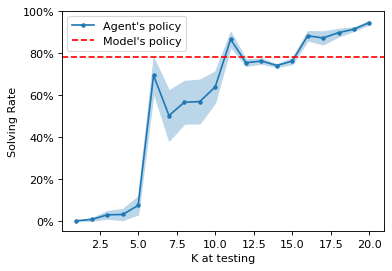

In [463]:
ys = []
xs = []
for run in runs:
    x, y = [], []
    for k in range(1, 21):
        x.append(k)
        y.append(scores_sokoban_inf_k[run]["%dK_test" % k])
    xs.append(x)
    ys.append(y)

xs = np.array([xs[0]])
ys = np.array([ys])
ax = plot(
    xs,
    ys,
    labels=["Agent's policy"],
    xlabel="K at testing",
    nolegend=True,
    linestyle=".-",
)

ys = []
for run in runs:
    ys.append(scores_sokoban_inf_k[run]["model_20K_test"] * 100)

ax.axhline(np.mean(ys), label="Model's policy", color="r", linestyle="--")
plt.legend()
plt.savefig(
    "/home/scuk/RS/thinker_paper/main_sokoban_infK.eps", dpi=300, bbox_inches="tight"
)

In [464]:
# main Sokoban results
base_path = "/home/scuk/logs/v13"
runs = [
    "v13_0.7b6",
    "v13_0.7b6_r1",
    "v13_0.7b6_r2",
    "v13_b_0.7b6",
    "v13_b_0.7b6_r1",
    "v13_b_0.7b6_r2",
    "v13_b_drc_0.7b6",
    "v13_b_drc_0.7b6_r4",
    "v13_b_drc_0.7b6_r5",
]
scores_sokoban = {}
for run in runs:
    scores_sokoban[run] = read_run(base_path, run, mean_n=200, tran=True)

Reading v13_0.7b6 max_actor_id 64
Reading v13_0.7b6_r1 max_actor_id 64
Reading v13_0.7b6_r2 max_actor_id 64
Reading v13_b_0.7b6 max_actor_id 128
Reading v13_b_0.7b6_r1 max_actor_id 128
Reading v13_b_0.7b6_r2 max_actor_id 128
Reading v13_b_drc_0.7b6 max_actor_id 128
Reading v13_b_drc_0.7b6_r4 max_actor_id 128
Reading v13_b_drc_0.7b6_r5 max_actor_id 128


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Frame to reach 0.80 score: Thinker-augment MDP:10500000; DRC:24500000


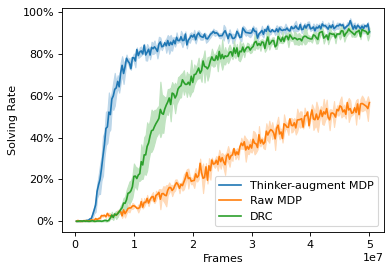

In [465]:
results = {
    "Thinker-augment MDP": ["v13_0.7b6", "v13_0.7b6_r1", "v13_0.7b6_r2"],
    "Raw MDP": ["v13_b_0.7b6", "v13_b_0.7b6_r1", "v13_b_0.7b6_r2"],
    "DRC": ["v13_b_drc_0.7b6", "v13_b_drc_0.7b6_r4", "v13_b_drc_0.7b6_r5"],
}
saveimg = "/home/scuk/RS/thinker_paper/main_sokoban.eps"

xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []
    for r in rs:
        y.append(scores_sokoban[r][1])
    ys.append(np.array(y))
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)

plot(xs, ys, labels, saveimg=saveimg)

index_0 = np.argmax(np.mean(ys[0], axis=0) >= 0.8)
frame_need_0 = xs[0][index_0]
index_2 = np.argmax(np.mean(ys[2], axis=0) >= 0.8)
frame_need_2 = xs[0][index_2]
print(
    f"Frame to reach 0.80 score: {labels[0]}:{frame_need_0}; {labels[2]}:{frame_need_2}"
)

In [467]:
# main Sokoban results - ablation on K
base_path = "/home/scuk/logs/v13"
runs = ["v13_0.7b6_10rect", "v13_0.7b6_5rect", "v13_0.7b6_2rect", "v13_0.7b6_1rect"]
for run in runs:
    scores_sokoban[run] = read_run(base_path, run, mean_n=200, tran=True)

Reading v13_0.7b6_10rect max_actor_id 64
Reading v13_0.7b6_5rect max_actor_id 64
Reading v13_0.7b6_2rect max_actor_id 64
Reading v13_0.7b6_1rect max_actor_id 64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Axes: xlabel='Frames', ylabel='Solving Rate'>

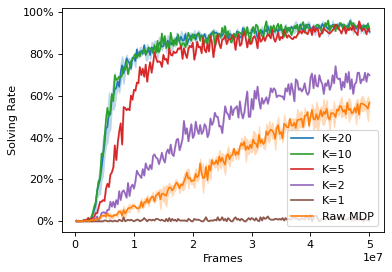

In [468]:
results = {
    "K=20": ["v13_0.7b6", "v13_0.7b6_r1", "v13_0.7b6_r2"],
    "K=10": ["v13_0.7b6_10rect"],
    "K=5": ["v13_0.7b6_5rect"],
    "K=2": ["v13_0.7b6_2rect"],
    "K=1": ["v13_0.7b6_1rect"],
    "Raw MDP": ["v13_b_0.7b6", "v13_b_0.7b6_r1", "v13_b_0.7b6_r2"],
}
saveimg = "/home/scuk/RS/thinker_paper/main_sokoban_K.eps"

xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []
    for r in rs:
        y.append(scores_sokoban[r][1])
    ys.append(np.array(y))
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)

plot(xs, ys, labels, saveimg=saveimg, color_orders=[0, 2, 3, 4, 5, 1])

In [98]:
# Table for Sokoban
base_path = "D:/data/thinker/logs/v13"
runs = [
    "v13_0.7b6",
    "v13_0.7b6_r1",
    "v13_0.7b6_r2",
    "v13_b_0.7b6",
    "v13_b_0.7b6_r1",
    "v13_b_0.7b6_r2",
    "v13_b_drc_0.7b6",
    "v13_b_drc_0.7b6_r4",
    "v13_b_drc_0.7b6_r5",
]
scores_sokoban_table = {}

for run in runs:
    path = os.path.join(base_path, run)
    score_run = {}

    for csv_file in glob.glob(os.path.join(path, "test", "*.csv")):
        name = os.path.basename(csv_file)
        pos = name.rfind("test_")
        if pos == 0:
            name = "base"
        else:
            name = name[: pos - 1]
        print(f"Adding results of {name} for run {run}")
        if name in score_run:
            print(f"Repeated run for {name} for run {run}, skipping")
            continue
        data = np.loadtxt(csv_file, delimiter=",")
        score_run[name] = np.mean(data > 5, axis=0)
        scores_sokoban_table[run] = score_run

Adding results of 10K_test for run v13_0.7b6
Adding results of 11K_test for run v13_0.7b6
Adding results of 12K_test for run v13_0.7b6
Adding results of 13K_test for run v13_0.7b6
Adding results of 14K_test for run v13_0.7b6
Adding results of 15K_test for run v13_0.7b6
Adding results of 16K_test for run v13_0.7b6
Adding results of 17K_test for run v13_0.7b6
Adding results of 18K_test for run v13_0.7b6
Adding results of 19K_test for run v13_0.7b6
Adding results of 1K_test for run v13_0.7b6
Adding results of 20K for run v13_0.7b6
Adding results of 20K_test for run v13_0.7b6
Adding results of 2K_test for run v13_0.7b6
Adding results of 3K_test for run v13_0.7b6
Adding results of 4K_test for run v13_0.7b6
Adding results of 5K_test for run v13_0.7b6
Adding results of 6K_test for run v13_0.7b6
Adding results of 7K_test for run v13_0.7b6
Adding results of 8K_test for run v13_0.7b6
Adding results of 9K_test for run v13_0.7b6
Adding results of greedy_20K for run v13_0.7b6
Adding results of gree

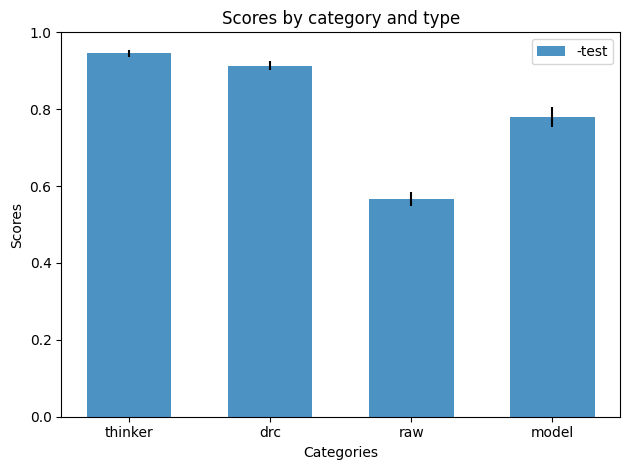

thinker: 94.5 0.8
drc: 91.3 1.2
raw: 56.7 1.9
model: 78.0 2.7


In [130]:
table = {}
table["thinker-test"] = [
    scores_sokoban_table["v13_0.7b6"]["20K_test"],
    scores_sokoban_table["v13_0.7b6_r1"]["20K_test"],
    scores_sokoban_table["v13_0.7b6_r2"]["20K_test"],
]
table["thinker-train"] = [
    scores_sokoban_table["v13_0.7b6"]["20K"],
    scores_sokoban_table["v13_0.7b6_r1"]["20K"],
    scores_sokoban_table["v13_0.7b6_r2"]["20K"],
]
table["model-test"] = [
    scores_sokoban_table["v13_0.7b6"]["model_20K_test"],
    scores_sokoban_table["v13_0.7b6_r1"]["model_20K_test"],
    scores_sokoban_table["v13_0.7b6_r2"]["model_20K_test"],
]
table["model-train"] = [
    scores_sokoban_table["v13_0.7b6"]["model_20K"],
    scores_sokoban_table["v13_0.7b6_r1"]["model_20K"],
    scores_sokoban_table["v13_0.7b6_r2"]["model_20K"],
]
table["raw-test"] = [
    scores_sokoban_table["v13_b_0.7b6"]["test"],
    scores_sokoban_table["v13_b_0.7b6_r1"]["test"],
    scores_sokoban_table["v13_b_0.7b6_r2"]["test"],
]
table["raw-train"] = [
    scores_sokoban_table["v13_b_0.7b6"]["base"],
    scores_sokoban_table["v13_b_0.7b6_r1"]["base"],
    scores_sokoban_table["v13_b_0.7b6_r2"]["base"],
]
table["drc-test"] = [
    scores_sokoban_table["v13_b_drc_0.7b6"]["test"],
    scores_sokoban_table["v13_b_drc_0.7b6_r4"]["test"],
    scores_sokoban_table["v13_b_drc_0.7b6_r5"]["test"],
]
table["drc-train"] = [
    scores_sokoban_table["v13_b_drc_0.7b6"]["base"],
    scores_sokoban_table["v13_b_drc_0.7b6_r4"]["base"],
    scores_sokoban_table["v13_b_drc_0.7b6_r5"]["base"],
]

# calculate mean and std
table_stats = {}
for key, values in table.items():
    table_stats[key] = {"mean": np.mean(values), "std": np.std(values)}

import matplotlib.pyplot as plt

categories = ["thinker", "drc", "raw", "model"]
# types = ["-train", "-test"]
types = ["-test"]
x = np.arange(len(categories))

fig, ax = plt.subplots()

bar_width = 0.6
opacity = 0.8

for i, t in enumerate(types):
    means = [table_stats[cat + t]["mean"] for cat in categories]
    stds = [table_stats[cat + t]["std"] for cat in categories]
    rects = ax.bar(
        x + i * bar_width, means, bar_width, yerr=stds, alpha=opacity, label=t
    )

ax.set_xlabel("Categories")
ax.set_ylabel("Scores")
ax.set_title("Scores by category and type")
ax.set_ylim(0, 1.0)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

fig.tight_layout()
plt.show()

for cat in categories:
    mean = table_stats[cat + "-test"]["mean"]
    std = table_stats[cat + "-test"]["std"]
    print("%s: %.1f %.1f" % (cat, mean * 100, std * 100))

In [11]:
from argparse import Namespace
import json
import csv

base_path = "/home/scuk/logs/v11"
mean_n = 500
log_freq = 250000
tran = False

result_atari = {}
for folder in glob.glob(os.path.join(base_path, "v11_*_0.7b6*")):
    env_name = "_".join(folder.split("_")[1:-1])
    if "0.7b6" in env_name:
        env_name = "_".join(env_name.split("_")[:-1])
    run = os.path.basename(folder)
    result_atari[run] = read_run(
        base_path, run, mean_n=mean_n, log_freq=log_freq, tran=False
    )

Reading v11_alien_0.7b6 max_actor_id 64
Reading v11_amidar_0.7b6 max_actor_id 32
Reading v11_assault_0.7b6 max_actor_id 64
Reading v11_asterix_0.7b6 max_actor_id 64
Reading v11_asteroids_0.7b6 max_actor_id 64
Reading v11_atlantis_0.7b6 max_actor_id 64
Reading v11_bank_heist_0.7b6 max_actor_id 64
Reading v11_battle_zone_0.7b6 max_actor_id 64
Reading v11_battle_zone_0.7b6_r1 max_actor_id 64
Reading v11_battle_zone_0.7b6_r2 max_actor_id 64
Reading v11_beam_rider_0.7b6 max_actor_id 64
Reading v11_berzerk_0.7b6 max_actor_id 64
Reading v11_bowling_0.7b6 max_actor_id 64
Reading v11_boxing_0.7b6 max_actor_id 32
Reading v11_breakout_0.7b6 max_actor_id 64
Reading v11_centipede_0.7b6 max_actor_id 64
Reading v11_chopper_command_0.7b6 max_actor_id 64
Reading v11_crazy_climber_0.7b6 max_actor_id 32
Reading v11_defender_0.7b6 max_actor_id 32
Reading v11_demon_attack_0.7b6 max_actor_id 32
Reading v11_double_dunk_0.7b6 max_actor_id 32
Reading v11_double_dunk_0.7b6_r1 max_actor_id 64
Reading v11_double_

In [137]:
base_path = "/home/scuk/logs/v11_b"
for folder in glob.glob(os.path.join(base_path, "v11_b_*_0.7b6*")):
    if "0.7b6" in env_name:
        env_name = "_".join(env_name.split("_")[:-1])
    run = os.path.basename(folder)
    result_atari[run] = read_run(
        base_path, run, mean_n=mean_n, log_freq=log_freq, tran=False
    )

Reading v11_b_alien_0.7b6 max_actor_id 128
Reading v11_b_amidar_0.7b6 max_actor_id 128
Reading v11_b_amidar_0.7b6_ max_actor_id 128
Reading v11_b_assault_0.7b6 max_actor_id 128
Reading v11_b_asterix_0.7b6 max_actor_id 128
Reading v11_b_asteroids_0.7b6 max_actor_id 128
Reading v11_b_atlantis_0.7b6 max_actor_id 128
Reading v11_b_bank_heist_0.7b6 max_actor_id 128
Reading v11_b_battle_zone_0.7b6 max_actor_id 128
Reading v11_b_beam_rider_0.7b6 max_actor_id 128
Reading v11_b_berzerk_0.7b6 max_actor_id 128
Reading v11_b_bowling_0.7b6 max_actor_id 128
Reading v11_b_boxing_0.7b6 max_actor_id 128
Reading v11_b_breakout_0.7b6 max_actor_id 128
Reading v11_b_centipede_0.7b6 max_actor_id 128
Reading v11_b_chopper_command_0.7b6 max_actor_id 128
Reading v11_b_crazy_climber_0.7b6 max_actor_id 128
Reading v11_b_defender_0.7b6 max_actor_id 128
Reading v11_b_demon_attack_0.7b6 max_actor_id 128
Reading v11_b_double_dunk_0.7b6 max_actor_id 128
Reading v11_b_enduro_0.7b6 max_actor_id 128
Reading v11_b_fishin

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


reading alien; found 1 run
reading amidar; found 1 run
reading assault; found 1 run
reading asterix; found 1 run
reading asteroids; found 1 run
reading atlantis; found 1 run
reading bank_heist; found 1 run
reading battle_zone; found 3 run
reading beam_rider; found 1 run
reading berzerk; found 1 run
reading bowling; found 1 run
reading boxing; found 1 run
reading breakout; found 1 run
reading centipede; found 1 run
reading chopper_command; found 1 run
reading crazy_climber; found 1 run
reading defender; found 1 run
reading demon_attack; found 1 run
reading double_dunk; found 3 run
reading enduro; found 1 run
reading fishing_derby; found 1 run
reading freeway; found 1 run
reading frostbite; found 1 run
reading gopher; found 1 run
reading gravitar; found 1 run
reading hero; found 1 run
reading ice_hockey; found 1 run
reading jamesbond; found 1 run
reading kangaroo; found 1 run
reading krull; found 1 run
reading kung_fu_master; found 1 run
reading montezuma_revenge; found 1 run
reading ms_

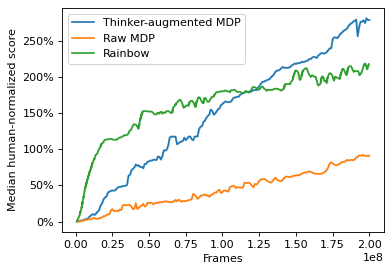

In [44]:
ret_len = 200
hns_thinker, hns_raw = {}, {}
hns_file = "/home/scuk/RS/thinker_paper/atari/hns.csv"
saveimg = "/home/scuk/RS/thinker_paper/main_atari.eps"
rainbow_path = "/home/scuk/RS/thinker_paper/atari/rainbow.csv"

mhns_rainbow = np.loadtxt(rainbow_path, delimiter=",")
mhns_rainbow[:, 0] *= 1e6
mhns_rainbow[:, 1] /= 1e2

hns_scores = {}
with open(hns_file, "r") as f:
    reader = csv.reader(f, delimiter=",")  # assuming your data is tab-separated
    for row in reader:
        key = row[0]
        values = np.array(
            row[1:], dtype=float
        )  # convert the values to float using numpy
        hns_scores[key] = values


def proc(score, hns_score, ret_len):
    # Normalizing the scores
    score = (score - hns_score[0]) / (hns_score[1] - hns_score[0])
    B = len(score)
    if B > ret_len:
        score = score[:ret_len]
    elif B < ret_len:
        last_item = score[-1]
        score = np.concatenate((score, np.full(ret_len - B, last_item)))
    return score


all_hns_thinker = np.zeros((len(hns_scores), ret_len))
for m, (env, hns_score) in enumerate(hns_scores.items()):
    run = "v11_%s_0.7b6" % env
    norm_scores = [proc(result_atari[run][1], hns_score, ret_len)]
    for n in range(10):
        run = "v11_%s_0.7b6_r%d" % (env, n)
        if run in result_atari:
            norm_scores.append(proc(result_atari[run][1], hns_score, ret_len))
    print("reading %s; found %d run" % (env, len(norm_scores)))
    norm_scores = np.mean(np.array(norm_scores), axis=0)
    hns_thinker[env] = norm_scores
    all_hns_thinker[m, :] = norm_scores

all_hns_raw = np.zeros((len(hns_scores), ret_len))
for m, (env, hns_score) in enumerate(hns_scores.items()):
    run = "v11_b_%s_0.7b6" % env
    norm_scores = [proc(result_atari[run][1], hns_score, ret_len)]
    for n in range(10):
        run = "v11_b_%s_0.7b6_r%d" % (env, n)
        if run in result_atari:
            norm_scores.append(proc(result_atari[run][1], hns_score, ret_len))
    print("reading %s; found %d run" % (env, len(norm_scores)))
    norm_scores = np.mean(np.array(norm_scores), axis=0)
    hns_raw[env] = norm_scores
    all_hns_raw[m, :] = norm_scores

x = log_freq * (np.arange(ret_len) + 1) * 4
ax = plot(
    xs=[x, x, mhns_rainbow[:, 0]],
    ys=[
        [np.median(all_hns_thinker, axis=0)],
        [np.median(all_hns_raw, axis=0)],
        [mhns_rainbow[:, 1]],
    ],
    labels=["Thinker-augmented MDP", "Raw MDP", "Rainbow"],
    ylabel="Median human-normalized score",
    saveimg=saveimg,
)

In [169]:
# output text for input to excel

import os
import glob
import numpy as np

base_path = "/home/scuk/logs/v11"
score_types = ["base", "greedy", "model"]
log_names = ["test*.csv", "greedy*.csv", "model*.csv"]
scores = {}

for folder in glob.glob(os.path.join(base_path, "v11_*_0.7b6*")):
    env_name = "_".join(folder.split("_")[1:-1])
    if "0.7b6" in env_name:
        env_name = "_".join(env_name.split("_")[:-1])
    test_subfolder = os.path.join(folder, "test")

    for n, score_type in enumerate(score_types):
        for csv_file in glob.glob(os.path.join(test_subfolder, log_names[n])):
            data = np.loadtxt(csv_file, delimiter=",")
            score = np.mean(data, axis=0)
            if env_name not in scores:
                scores[env_name] = {}
            if score_type in scores[env_name]:
                scores[env_name][score_type].append(score)
            else:
                scores[env_name][score_type] = [score]

for k, v in scores.items():
    out_str = k
    for score_type in score_types:
        if score_type in v:
            out_str += " %s %f (%d)" % (
                score_type,
                np.average(v[score_type]),
                len(v[score_type]),
            )
        else:
            out_str += " %s %f (%d)" % (score_type, 0, 0)
    print(out_str)

alien base 230.100000 (1) greedy 163.400000 (1) model 229.200000 (1)
amidar base 3591.840000 (1) greedy 3797.650000 (1) model 1338.750000 (1)
assault base 24262.470000 (1) greedy 26582.120000 (1) model 18856.510000 (1)
asterix base 85254.000000 (1) greedy 66881.000000 (1) model 238992.500000 (1)
asteroids base 212805.500000 (1) greedy 248878.500000 (1) model 40030.600000 (1)
atlantis base 809160.000000 (1) greedy 812499.000000 (1) model 808384.000000 (1)
bank_heist base 1528.900000 (1) greedy 1576.200000 (1) model 1531.200000 (1)
battle_zone base 48103.333333 (3) greedy 42840.000000 (3) model 47553.333333 (3)
beam_rider base 59533.140000 (1) greedy 69113.600000 (1) model 15213.500000 (1)
berzerk base 1038.300000 (1) greedy 1033.100000 (1) model 1024.600000 (1)
bowling base 31.140000 (1) greedy 27.140000 (1) model 31.260000 (1)
boxing base 99.860000 (1) greedy 100.000000 (1) model 99.510000 (1)
breakout base 840.140000 (1) greedy 605.970000 (1) model 660.840000 (1)
centipede base 6507.0

In [46]:
base_path = "/home/scuk/logs/v11_b"
score_types = ["base", "greedy"]
log_names = ["test*.csv", "greedy*.csv"]
scores = {}

for folder in glob.glob(os.path.join(base_path, "v11_b_*_0.7b6*")):
    env_name = "_".join(folder.split("_")[3:-1])
    if "0.7b6" in env_name:
        env_name = "_".join(env_name.split("_")[:-1])
    test_subfolder = os.path.join(folder, "test")

    for n, score_type in enumerate(score_types):
        for csv_file in glob.glob(os.path.join(test_subfolder, log_names[n])):
            data = np.loadtxt(csv_file, delimiter=",")
            score = np.mean(data, axis=0)
            if env_name not in scores:
                scores[env_name] = {}
            if score_type in scores[env_name]:
                scores[env_name][score_type].append(score)
            else:
                scores[env_name][score_type] = [score]

for k, v in scores.items():
    out_str = k
    for score_type in score_types:
        if score_type in v:
            out_str += " %s %f (%d)" % (
                score_type,
                np.average(v[score_type]),
                len(v[score_type]),
            )
        else:
            out_str += " %s %f (%d)" % (score_type, 0, 0)
    print(out_str)

alien base 13868.800000 (1) greedy 14570.400000 (1)
amidar base 1121.555000 (2) greedy 1202.050000 (2)
assault base 6998.290000 (1) greedy 7190.800000 (1)
asterix base 279440.000000 (1) greedy 303160.000000 (1)
asteroids base 12570.400000 (1) greedy 14328.900000 (1)
atlantis base 896017.000000 (1) greedy 897777.000000 (1)
bank_heist base 378.500000 (1) greedy 376.000000 (1)
battle_zone base 2320.000000 (1) greedy 0.000000 (1)
beam_rider base 24202.460000 (1) greedy 24762.900000 (1)
berzerk base 2664.000000 (1) greedy 3313.400000 (1)
bowling base 23.780000 (1) greedy 30.000000 (1)
boxing base 8.170000 (1) greedy -1.700000 (1)
breakout base 593.830000 (1) greedy 381.220000 (1)
centipede base 8201.710000 (1) greedy 7531.000000 (1)
chopper_command base 1046.000000 (1) greedy 1100.000000 (1)
crazy_climber base 97824.000000 (1) greedy 76804.000000 (1)
defender base 385397.500000 (1) greedy 401405.000000 (1)
demon_attack base 502.300000 (1) greedy 740.100000 (1)
double_dunk base -1.720000 (1)

In [212]:
# Appendix, all atari games learning curve

rainbow_run_path = "/home/scuk/RS/thinker_paper/atari/rainbow/"
result_rainbow = {}
for folder in glob.glob(os.path.join(rainbow_run_path, "*")):
    with open(folder, "r") as f:
        run = os.path.basename(folder)[:-4]
        reader = csv.reader(f, delimiter=",")  # assuming your data is tab-separated
        results = []
        for row in reader:
            results.append(np.array(row, dtype=float))
        results = np.array(results)
        results[:, 0] *= 2e8
        sorted_indices = np.argsort(results[:, 0])
        result_rainbow[run] = results[sorted_indices]

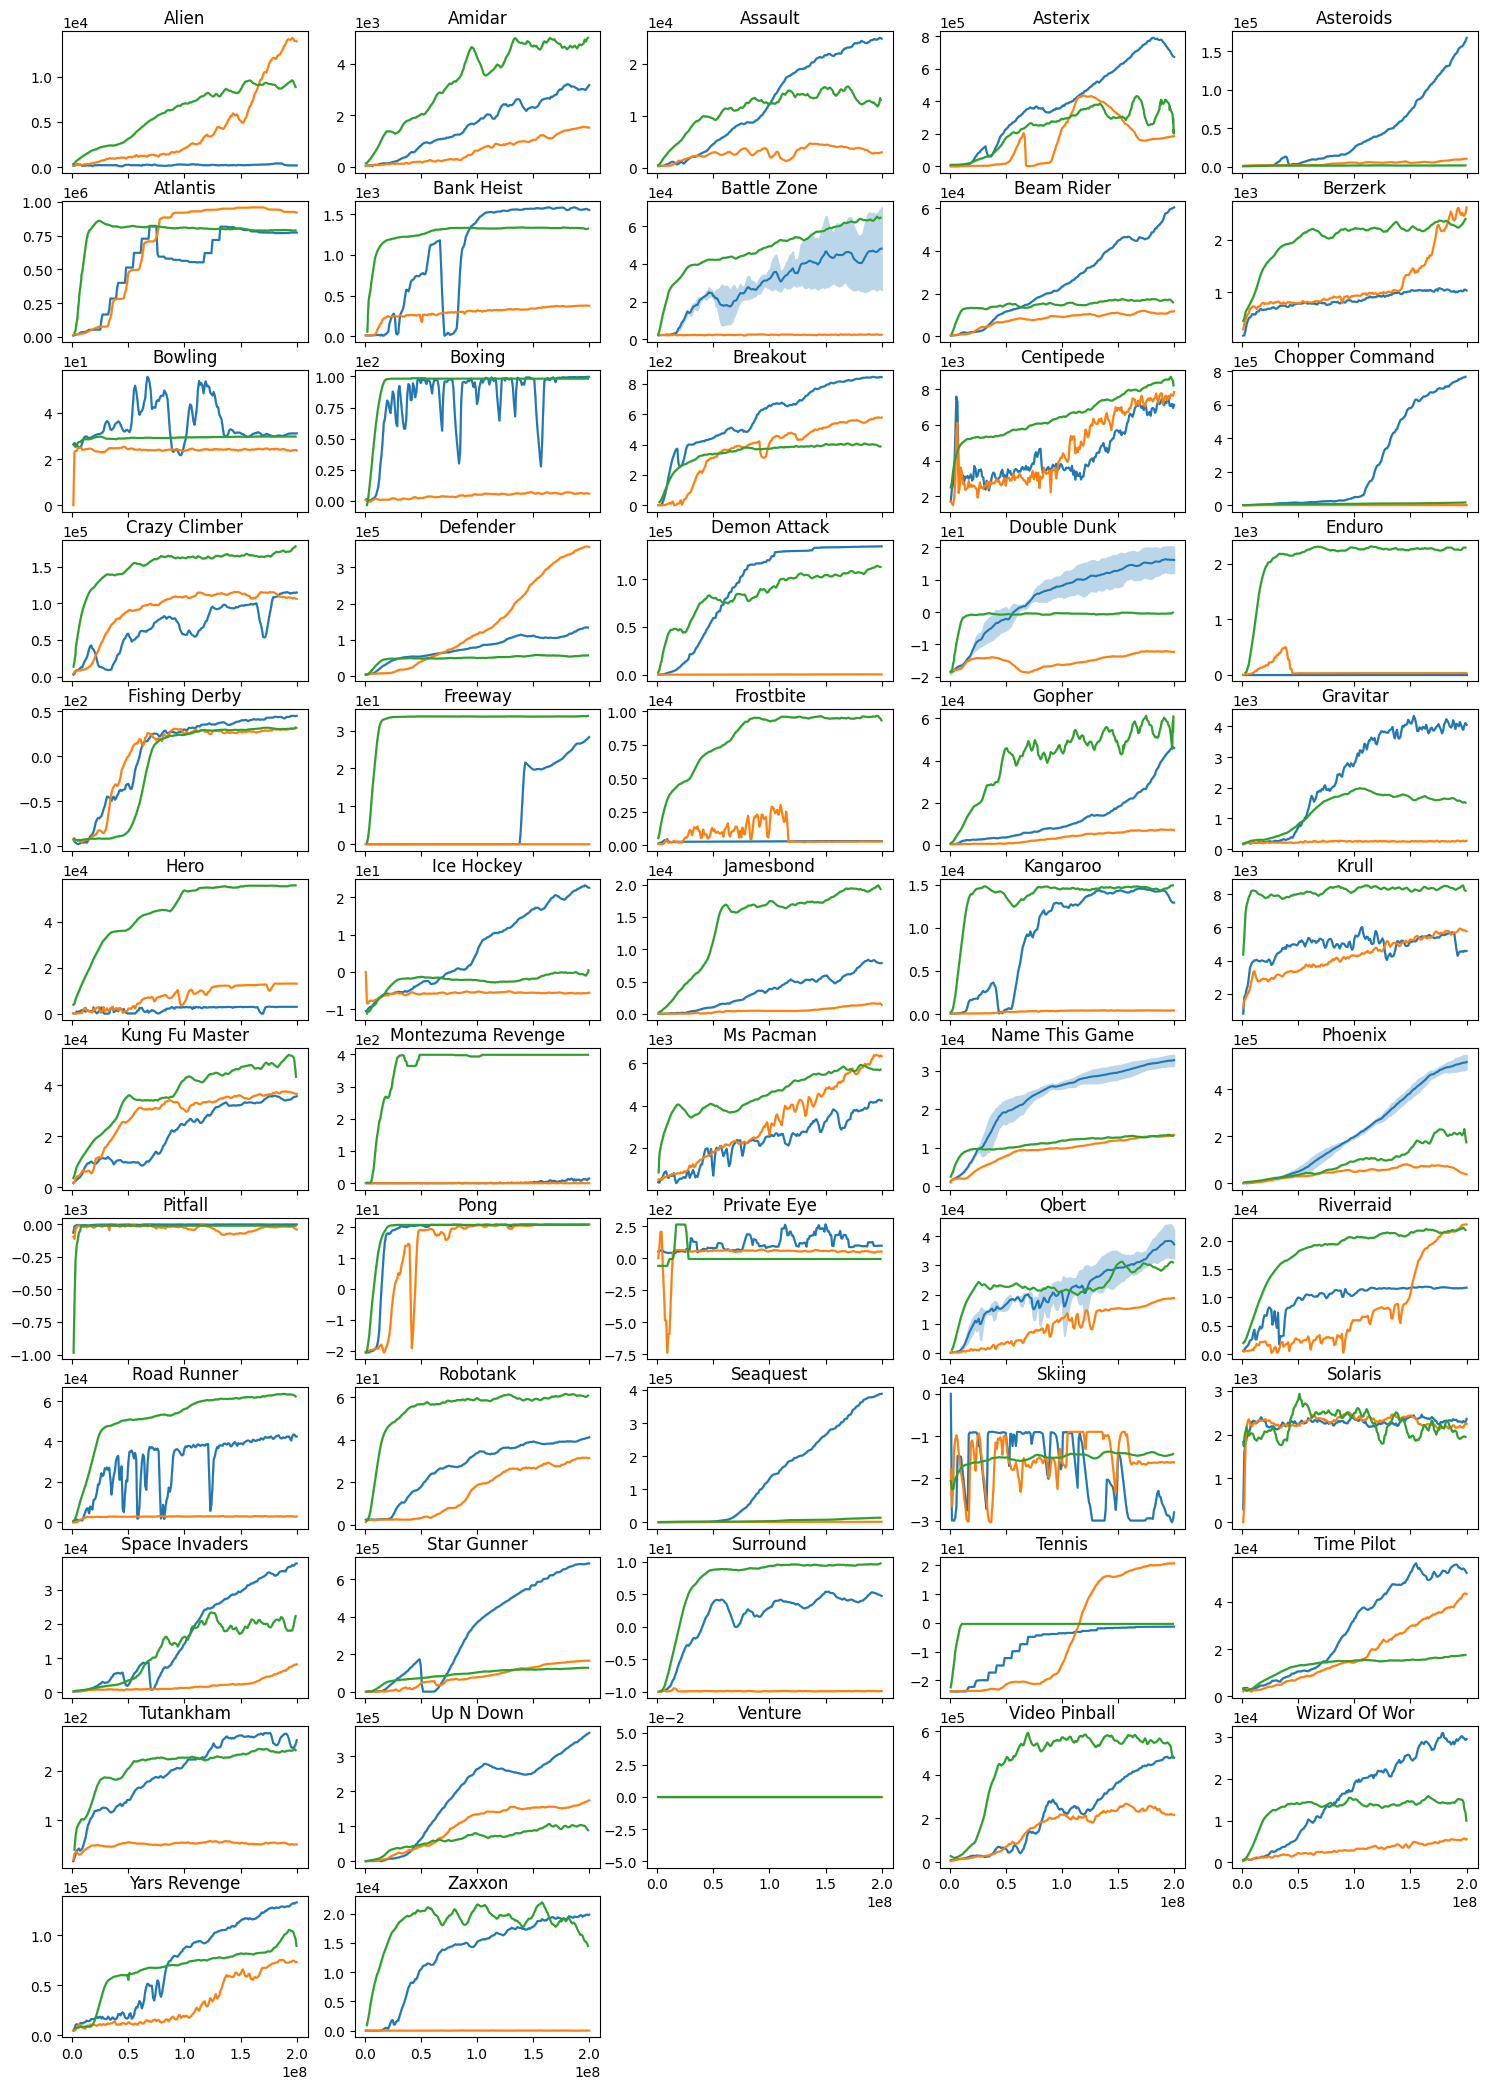

In [214]:
saveimg = "/home/scuk/RS/thinker_paper/app_atari_all.svg"

env_names = list(hns_scores.keys())
fig, axes = plt.subplots(12, 5, figsize=(5 * 3, 7 * 3))
idx_x, idx_y = 0, 0

for env_name in env_names:
    ax = axes[idx_x, idx_y]

    xs, ys = [], []
    run = result_atari["v11_%s_0.7b6" % env_name]
    xs.append(np.array(run[0]) * 4)
    ys.append([run[1]])

    for n in range(1, 3):
        rname = "v11_%s_0.7b6_r%d" % (env_name, n)
        if rname in result_atari.keys():
            run = result_atari[rname]
            ys[-1].append(run[1])
    ys[-1] = np.array(ys[-1])

    run = result_atari["v11_b_%s_0.7b6" % env_name]
    xs.append(np.array(run[0]) * 4)
    ys.append([run[1]])

    xs.append(result_rainbow[env_name][:, 0])
    ys.append([result_rainbow[env_name][:, 1]])
    labels = ["Thinker-augmented MDP", "Raw MDP", "Rainbow"]
    title = env_name.replace("_", " ").title()
    if env_name == "up_ndown":
        title = "Up N Down"
    noxtick = idx_y + idx_x * 5 < 52
    plot(
        xs=xs,
        ys=ys,
        labels=labels,
        per=False,
        xlabel="",
        ylabel="",
        noxtick=noxtick,
        nolegend=True,
        title=title,
        ax=ax,
    )
    idx_y += 1
    if idx_y >= 5:
        idx_x += 1
        idx_y = 0

while True:
    ax = axes[idx_x, idx_y]
    ax.axis("off")
    ax.set_frame_on(False)
    idx_y += 1
    if idx_y >= 5:
        break

# plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.19)
plt.savefig(saveimg, dpi=300, bbox_inches="tight")

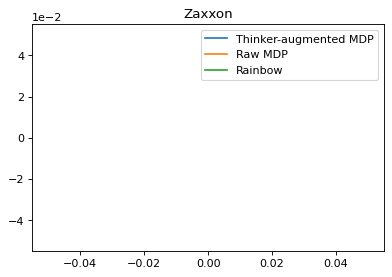

In [164]:
plot(
    xs=[[0], [0], [0]],
    ys=[[[0]], [[0]], [[0]]],
    labels=labels,
    per=False,
    xlabel="",
    ylabel="",
    noxtick=noxtick,
    nolegend=False,
    title=title,
)
plt.savefig("/home/scuk/RS/thinker_paper/legend.svg", dpi=300, bbox_inches="tight")

In [178]:
# Reproduce

atari_5_env_names = ["battle_zone", "double_dunk", "name_this_game", "phoenix", "qbert"]
for env_name in atari_5_env_names:
    pretty_env_name = env_name.replace("_", " ").title()
    s = pretty_env_name

    for n in scores[env_name]["base"]:
        s += " & %.2f" % n
    s += " & %.2f \\\\" % (np.mean(scores[env_name]["base"]))
    print(s)

Battle Zone & 78740.00 & 31110.00 & 34460.00 & 48103.33 \\
Double Dunk & 12.20 & 14.54 & 21.54 & 16.09 \\
Name This Game & 34079.60 & 33400.20 & 31775.80 & 33085.20 \\
Phoenix & 543987.70 & 535685.10 & 578485.30 & 552719.37 \\
Qbert & 30734.50 & 36810.25 & 37003.25 & 34849.33 \\


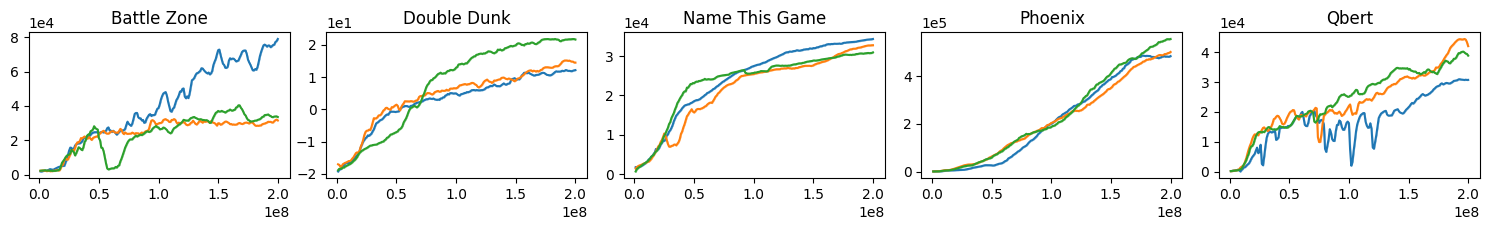

In [201]:
fig, axes = plt.subplots(1, 5, figsize=(5 * 3, 0.8 * 3))
for m, env_name in enumerate(atari_5_env_names):
    ax = axes[m]

    xs, ys = [], []
    run = result_atari["v11_%s_0.7b6" % env_name]
    xs.append(np.array(run[0]) * 4)
    ys.append([run[1]])

    for n in range(1, 3):
        rname = "v11_%s_0.7b6_r%d" % (env_name, n)
        if rname in result_atari.keys():
            run = result_atari[rname]
            xs.append(np.array(run[0]) * 4)
            ys.append([run[1]])
    title = env_name.replace("_", " ").title()
    labels = ["Seed 1", "Seed 2", "Seed 3"]
    plot(
        xs=xs,
        ys=ys,
        labels=labels,
        per=False,
        xlabel="",
        ylabel="",
        noxtick=noxtick,
        nolegend=True,
        title=title,
        ax=ax,
    )

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.14)
plt.savefig("/home/scuk/RS/thinker_paper/app_atari5.svg", dpi=300, bbox_inches="tight")

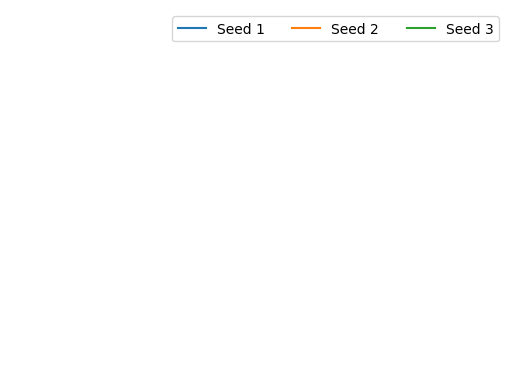

In [210]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create custom artists
SimArtist = plt.Line2D((0, 1), (0, 0), color="C0", linestyle="-")
RealArtist = plt.Line2D((0, 1), (0, 0), color="C1", linestyle="-")
EstArtist = plt.Line2D((0, 1), (0, 0), color="C2", linestyle="-")
# Create legend from custom artist/label lists
plt.legend([SimArtist, RealArtist, EstArtist], ["Seed 1", "Seed 2", "Seed 3"], ncol=3)
# Hide the axis
plt.gca().set_axis_off()
plt.savefig("/home/scuk/RS/thinker_paper/legend2.svg", dpi=300, bbox_inches="tight")
plt.show()

Learned Agent Analaysis

In [76]:
# collect data and some util functions


def plot_count(
    datasets,
    labels,
    xlabel,
    ylabel,
    title="",
    ax=None,
    size=1,
    nolegend=False,
    ylim=None,
):
    # Number of datasets
    n = len(datasets)
    # Width of bars in the plot
    width = 1.0 / (n + 1)
    # Create a new figure
    if ax is None:
        plt.figure(figsize=(5 * size, 3 * size), dpi=80)
        ax = plt.gca()

    max_value = max([max(data) for data in datasets])
    x_ticks = np.arange(1, max_value + 2)

    # Initialize array to store all percentages
    all_percentages = []

    # For each dataset...
    for i, data in enumerate(datasets):
        # Compute counts and percentages
        counts = np.bincount(data, minlength=max_value + 1)
        percentages = counts / len(data) * 100
        all_percentages.append(percentages)
        x = np.arange(len(counts)) + 1
        # Plot the histogram
        ax.bar(
            x + (i - 0.5 * (n - 1)) * width,
            percentages,
            width=width,
            label=labels[i],
            align="center",
        )

    # Calculate standard error for each possible value
    all_percentages = np.array(all_percentages)

    # Set title and labels
    if title is not None:
        ax.set_title(title)
    ax.set_xticks(x_ticks)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Add a legend
    if not nolegend:
        ax.legend()
    if ylim is not None:
        ax.set_ylim(ylim)


def load_data(
    check_point_path, max_eps_n, batch_size=10, collect_expand=False, debug_done=True
):
    device = torch.device("cuda")
    flags = util.parse(["--load_checkpoint", check_point_path])
    env = Environment(
        flags,
        env_n=batch_size,
        model_wrap=True,
        debug=True,
        device=device,
        debug_done=debug_done,
    )
    num_actions = env.num_actions
    seed = np.arange(batch_size)
    env.seed(seed)
    model_net = ModelNet(
        obs_shape=env.gym_env_out_shape,
        num_actions=env.num_actions,
        flags=flags,
        debug=True,
    )
    model_net.train(False)

    model_path = os.path.join(check_point_path, "ckp_model.tar")
    checkpoint = torch.load(model_path, torch.device("cpu"))
    model_net.set_weights(
        checkpoint["model_state_dict"]
        if "model_state_dict" in checkpoint
        else checkpoint["model_net_state_dict"]
    )
    model_net.to(device)

    actor_net = ActorNet(
        obs_shape=env.model_out_shape,
        gym_obs_shape=env.gym_env_out_shape,
        num_actions=env.num_actions,
        flags=flags,
    )
    checkpoint = torch.load(
        os.path.join(check_point_path, "ckp_actor.tar"), torch.device("cpu")
    )
    actor_net.set_weights(checkpoint["actor_net_state_dict"])
    actor_net.to(device)
    actor_state = actor_net.initial_state(batch_size=batch_size, device=device)

    with torch.no_grad():
        env_out = env.initial(model_net)
        returns = []
        real_stats = {"action": [], "model_stat": []}
        all_stats = {"action": [], "model_stat": [], "expand_stat": []}
        while len(returns) < max_eps_n:
            actor_out, actor_state = actor_net(env_out, actor_state)
            action = [actor_out.action, actor_out.im_action, actor_out.reset_action]
            action = torch.stack(action, dim=-1)
            model_out_ = util.decode_model_out(
                env_out.model_out, num_actions, flags.model_enc_type
            )

            if collect_expand:
                h_stat = env_out.model_encodes[0, :, :128, :, :]
                h_non_stat = env_out.model_encodes[0, :, 128:, :, :]
                state = {"m_h": h_stat, "p_h": h_non_stat}
                outs = []
                for m in range(num_actions):
                    out = model_net.forward_single(
                        state,
                        action=torch.tensor(
                            [
                                m,
                            ]
                            * batch_size,
                            device=device,
                            dtype=torch.long,
                        ),
                        one_hot=False,
                    )
                    outs.append(out)

            env_out = env.step(action, model_net)

            all_stats["action"].append(action[0])
            all_stats["model_stat"].append(model_out_)
            if env_out.cur_t[0, 0] == 0:
                # real action is just taken
                real_stats["action"].append(actor_out.action[0])
                real_stats["model_stat"].append(model_out_)
            if collect_expand:
                all_stats["expand_stat"].append(outs)
            if torch.any(env_out.real_done):
                new_rets = env_out.episode_return[env_out.real_done][:, 0].cpu().numpy()
                returns.extend(new_rets)
                print(
                    "Finish %d episode: avg. return: %.2f (+-%.2f) "
                    % (
                        len(returns),
                        np.average(returns),
                        np.std(returns) / np.sqrt(len(returns)),
                    )
                )

    return real_stats, all_stats


def concat_d(d, item=None):
    if item is not None:
        return np.concatenate([x[item].cpu().numpy() for x in d])
    else:
        return np.concatenate([x.cpu().numpy() for x in d])


def ucb(model_stat, K=20):
    q_min, q_max = -1.2, 7
    cur_q = torch.clone(model_stat["cur_qs_mean"])
    cur_q[model_stat["reset"] == 1] = model_stat["root_qs_mean"][
        model_stat["reset"] == 1
    ]
    qsa = (cur_q - q_min) / (q_max - q_min)
    cur_logits = torch.clone(model_stat["cur_logits"])
    cur_logits[model_stat["reset"] == 1] = model_stat["root_logits"][
        model_stat["reset"] == 1
    ]
    psa = torch.nn.functional.softmax(cur_logits, dim=-1)
    cur_ns = torch.clone(model_stat["cur_ns"])
    cur_ns[model_stat["reset"] == 1] = model_stat["root_ns"][model_stat["reset"] == 1]
    nsa = cur_ns * K
    c_1 = 1.25
    c_2 = 19625

    sum_nsa = torch.sum(nsa, dim=-1, keepdim=True)
    l = qsa + psa * (torch.sqrt(sum_nsa)) / (1 + nsa) * (
        c_1 + torch.log((sum_nsa + c_2 + 1) / c_2)
    )
    sel_action = torch.argmax(l, dim=-1)
    return sel_action

In [31]:
check_point_path = "/home/scuk/logs/v13/v13_0.7b6_r2"
check_point_path_noim = "/home/scuk/logs/v13/v13_0.7b6_norew"
check_point_path_noimb = "/home/scuk/logs/v13/v13_0.76b_norew_10L"

max_eps_n = 20000
batch_size = 32

real_stats_base, all_stats_base = load_data(
    check_point_path, max_eps_n, batch_size=batch_size, collect_expand=False
)
real_stats_noim, all_stats_noim = load_data(
    check_point_path_noim, max_eps_n, batch_size=batch_size, collect_expand=False
)
real_stats_noimb, all_stats_noimb = load_data(
    check_point_path_noimb, max_eps_n, batch_size=batch_size, collect_expand=False
)

Finish 32 episode: avg. return: 0.12 (+-0.06) 
Finish 64 episode: avg. return: 0.10 (+-0.04) 
Finish 96 episode: avg. return: 0.07 (+-0.03) 
Finish 128 episode: avg. return: 0.06 (+-0.02) 
Finish 160 episode: avg. return: 0.06 (+-0.02) 
Finish 192 episode: avg. return: 0.07 (+-0.02) 
Finish 224 episode: avg. return: 0.07 (+-0.02) 
Finish 256 episode: avg. return: 0.07 (+-0.02) 
Finish 288 episode: avg. return: 0.07 (+-0.02) 
Finish 320 episode: avg. return: 0.07 (+-0.02) 
Finish 352 episode: avg. return: 0.07 (+-0.01) 
Finish 384 episode: avg. return: 0.07 (+-0.01) 
Finish 416 episode: avg. return: 0.07 (+-0.01) 
Finish 448 episode: avg. return: 0.08 (+-0.01) 
Finish 480 episode: avg. return: 0.08 (+-0.01) 
Finish 512 episode: avg. return: 0.08 (+-0.01) 
Finish 544 episode: avg. return: 0.08 (+-0.01) 
Finish 576 episode: avg. return: 0.08 (+-0.01) 
Finish 608 episode: avg. return: 0.08 (+-0.01) 
Finish 640 episode: avg. return: 0.08 (+-0.01) 
Finish 672 episode: avg. return: 0.08 (+-0.

In [32]:
# mean expansion length
def compute_expand_lengths(all_stats):
    expand_lengths = []
    new_expansion_count = np.zeros(batch_size)
    for n in range(len(all_stats["action"])):
        action = all_stats["action"][n]
        model_stat = all_stats["model_stat"][n]
        for m in range(batch_size):
            root_ns = model_stat["root_ns"][m]
            im_action = action[m, 1]
            reset = model_stat["reset"][m]
            real_step = model_stat["time"][m][-1] == 1
            if root_ns[im_action] == 0.0 and not real_step:
                new_expansion_count[m] += 1
            if real_step or reset:
                if new_expansion_count[m] > 0:
                    expand_lengths.append(new_expansion_count[m])
                new_expansion_count[m] = 0
    expand_lengths = np.array(expand_lengths, int)
    return expand_lengths - 1


expand_lengths_base = compute_expand_lengths(all_stats_base)
expand_lengths_noim = compute_expand_lengths(all_stats_noim)
expand_lengths_noimb = compute_expand_lengths(all_stats_noimb)

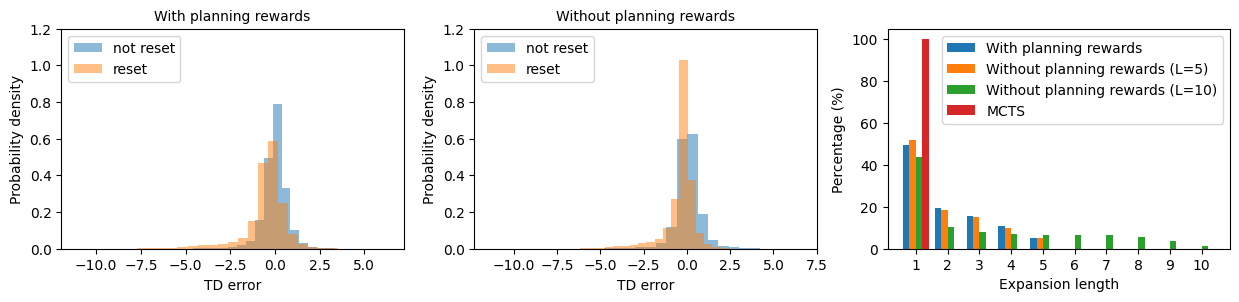

In [33]:
# reset action analysis


def plot_reset_td(all_stats, title="", ax=None, size=1):
    reset_action = np.concatenate([x[:, 2].cpu().numpy() for x in all_stats["action"]])
    td_error = (
        concat_d(all_stats["model_stat"], "root_trail_q")
        - concat_d(all_stats["model_stat"], "root_v")
    )[:, 0]

    # Separate td_error values based on reset_action
    td_error_when_reset_0 = td_error[reset_action == 0]
    td_error_when_reset_1 = td_error[reset_action == 1]

    # Plot histograms
    if ax is None:
        plt.figure(figsize=(5 * size, 3.5 * size), dpi=80)
        ax = plt.gca()
    ax.hist(td_error_when_reset_0, bins=30, alpha=0.5, label="not reset", density=True)
    ax.hist(td_error_when_reset_1, bins=30, alpha=0.5, label="reset", density=True)
    if title:
        ax.set_title(title, fontsize=10)
    # Setting the legend
    ax.legend(loc="upper left")
    ax.set_xlabel("TD error")
    ax.set_ylabel("Probability density")
    ax.set_ylim([0, 1.2])


fig, axes = plt.subplots(1, 3, figsize=(20 / 1.6, 5 / 1.6))
plot_reset_td(all_stats_base, ax=axes[0], title="With planning rewards")
plot_reset_td(all_stats_noim, ax=axes[1], title="Without planning rewards")

plot_count(
    [expand_lengths_base, expand_lengths_noim, expand_lengths_noimb, np.zeros(1, int)],
    labels=[
        "With planning rewards",
        "Without planning rewards (L=5)",
        "Without planning rewards (L=10)",
        "MCTS",
    ],
    xlabel="Expansion length",
    ylabel="Percentage (%)",
    ax=axes[2],
)
plt.tight_layout()
plt.savefig("/home/scuk/RS/thinker_paper/app_reset.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [77]:
# imaginary aciton analysis
import seaborn as sns


def load_data_multi_policy(
    check_point_path, max_eps_n, batch_size=10, real_policy="base", debug_done=True
):
    policy_types = ["base", "random", "ucb"]

    device = torch.device("cuda")
    flags = util.parse(["--load_checkpoint", check_point_path])
    flags.tree_carry = False
    test_n = len(policy_types)
    envs = [
        Environment(
            flags,
            env_n=batch_size,
            model_wrap=True,
            debug=True,
            device=device,
            debug_done=debug_done,
        )
        for n in range(test_n)
    ]
    num_actions = envs[0].num_actions
    seed = np.arange(batch_size)
    for env in envs:
        env.seed(seed)
    model_net = ModelNet(
        obs_shape=envs[0].gym_env_out_shape,
        num_actions=env.num_actions,
        flags=flags,
        debug=True,
    )
    model_net.train(False)

    model_path = os.path.join(check_point_path, "ckp_model.tar")
    checkpoint = torch.load(model_path, torch.device("cpu"))
    model_net.set_weights(
        checkpoint["model_state_dict"]
        if "model_state_dict" in checkpoint
        else checkpoint["model_net_state_dict"]
    )
    model_net.to(device)

    actor_net = ActorNet(
        obs_shape=env.model_out_shape,
        gym_obs_shape=env.gym_env_out_shape,
        num_actions=env.num_actions,
        flags=flags,
    )
    checkpoint = torch.load(
        os.path.join(check_point_path, "ckp_actor.tar"), torch.device("cpu")
    )
    actor_net.set_weights(checkpoint["actor_net_state_dict"])
    actor_net.to(device)
    actor_net.train(False)
    actor_state = actor_net.initial_state(batch_size=batch_size, device=device)

    with torch.no_grad():
        env_outs = [env.initial(model_net) for env in envs]

        returns = []
        all_stats = {}
        for policy in policy_types:
            all_stats[policy] = {"model_stat": [], "action": [], "reward": []}

        while len(returns) < max_eps_n:
            for n, policy in enumerate(policy_types):
                env_out = env_outs[n]
                model_out = util.decode_model_out(
                    env_out.model_out, num_actions, flags.model_enc_type
                )

                if policy == "base":
                    actor_out, actor_state = actor_net(env_out, actor_state)
                    action = [
                        actor_out.action,
                        actor_out.im_action,
                        actor_out.reset_action,
                    ]
                elif policy == "random":
                    action = [
                        torch.randint(
                            low=0,
                            high=num_actions,
                            size=(
                                1,
                                batch_size,
                            ),
                            device=device,
                        ),
                        torch.randint(
                            low=0,
                            high=num_actions,
                            size=(
                                1,
                                batch_size,
                            ),
                            device=device,
                        ),
                        torch.randint(
                            low=0,
                            high=2,
                            size=(
                                1,
                                batch_size,
                            ),
                            device=device,
                        ),
                    ]
                elif policy == "ucb":
                    # real action
                    temp = 0.25
                    root_ns = torch.clone(model_out["root_ns"]) * flags.rec_t
                    n_temp = root_ns ** (1 / temp) + 1e-7
                    p = n_temp / torch.sum(n_temp, dim=-1, keepdim=True)
                    real_action = torch.multinomial(p, num_samples=1)[:, 0]
                    # imagainary action
                    ucb_action = ucb(model_out)
                    # reset action
                    cur_ns = torch.clone(model_out["cur_ns"])
                    cur_ns[model_out["reset"] == 1] = model_out["root_ns"][
                        model_out["reset"] == 1
                    ]
                    reset = (torch.sum(cur_ns, dim=-1) <= 0).long()

                    action = [
                        real_action.unsqueeze(0),
                        ucb_action.unsqueeze(0),
                        reset.unsqueeze(0),
                    ]

                action = torch.stack(action, dim=-1)
                all_stats[policy]["model_stat"].append(model_out)
                all_stats[policy]["action"].append(action)
                all_stats[policy]["reward"].append(env_out.reward)

            env_outs = []
            for n, policy in enumerate(policy_types):
                action = all_stats[policy]["action"][-1]
                action[:, :, 0] = all_stats[real_policy]["action"][-1][
                    :, :, 0
                ]  # replace real action
                env_outs.append(envs[n].step(action, model_net))

            if torch.any(env_outs[0].real_done):
                new_rets = (
                    env_outs[0]
                    .episode_return[env_outs[0].real_done][:, 0]
                    .cpu()
                    .numpy()
                )
                returns.extend(new_rets)
                print(
                    "Finish %d episode: avg. return: %.2f (+-%.2f) "
                    % (
                        len(returns),
                        np.average(returns),
                        np.std(returns) / np.sqrt(len(returns)),
                    )
                )

    return all_stats, returns


check_point_path = "/home/scuk/logs/v13/v13_0.7b6_r2"
check_point_path_noim = "/home/scuk/logs/v13/v13_0.7b6_norew"
max_eps_n = 20000
batch_size = 32

real_policy = "base"
m_all_stats_base, returns_base = load_data_multi_policy(
    check_point_path, max_eps_n, batch_size=batch_size, real_policy=real_policy
)
m_all_stats_noim, returns_noim = load_data_multi_policy(
    check_point_path_noim, max_eps_n, batch_size=batch_size, real_policy=real_policy
)

Finish 32 episode: avg. return: 0.12 (+-0.06) 
Finish 64 episode: avg. return: 0.12 (+-0.04) 
Finish 96 episode: avg. return: 0.08 (+-0.03) 
Finish 128 episode: avg. return: 0.07 (+-0.02) 
Finish 160 episode: avg. return: 0.06 (+-0.02) 
Finish 192 episode: avg. return: 0.08 (+-0.02) 
Finish 224 episode: avg. return: 0.07 (+-0.02) 
Finish 256 episode: avg. return: 0.08 (+-0.02) 
Finish 288 episode: avg. return: 0.07 (+-0.02) 
Finish 320 episode: avg. return: 0.07 (+-0.02) 
Finish 352 episode: avg. return: 0.07 (+-0.01) 
Finish 384 episode: avg. return: 0.07 (+-0.01) 
Finish 416 episode: avg. return: 0.07 (+-0.01) 
Finish 448 episode: avg. return: 0.08 (+-0.01) 
Finish 480 episode: avg. return: 0.08 (+-0.01) 
Finish 512 episode: avg. return: 0.08 (+-0.01) 
Finish 544 episode: avg. return: 0.08 (+-0.01) 
Finish 576 episode: avg. return: 0.08 (+-0.01) 
Finish 608 episode: avg. return: 0.08 (+-0.01) 
Finish 640 episode: avg. return: 0.08 (+-0.01) 
Finish 672 episode: avg. return: 0.08 (+-0.

(20000,)
(20000,)
(20000,)
(20000,)
(20000,)
(20000,)
(20000,)
(20000,)
(20000,)
(20000,)
(20000,)
(20000,)


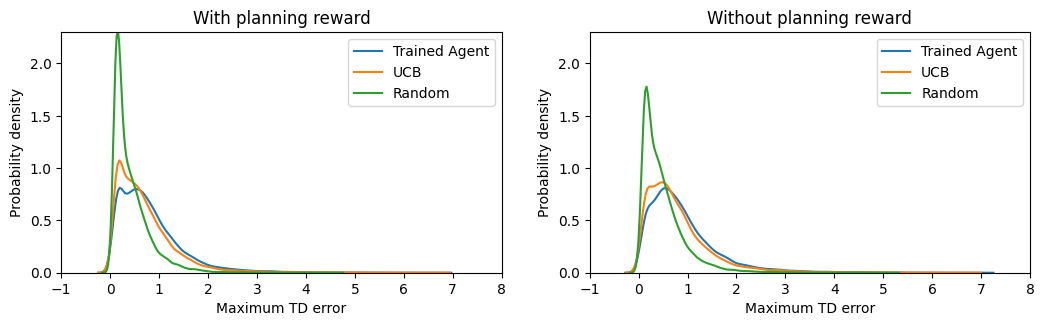

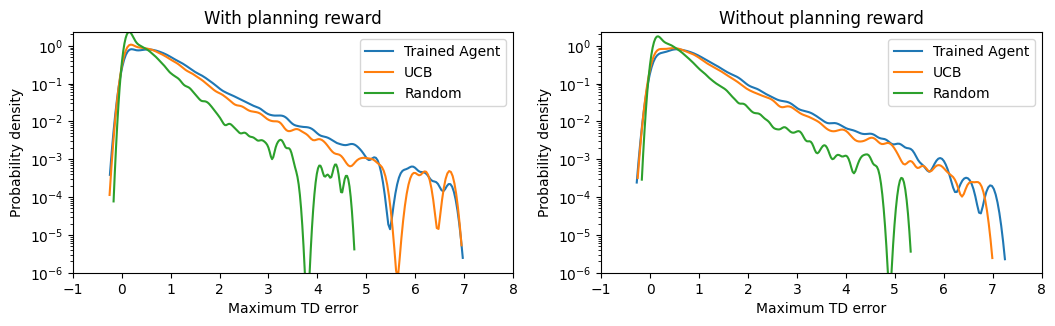

In [79]:
def plot_max_qs(max_qs, ax, labels, title="", logscale=False):
    for m, (k, n) in enumerate(max_qs.items()):
        sns.kdeplot(n, label=labels[m], bw_adjust=1, ax=ax)
    # Setting the legend
    ax.legend(loc="upper right")
    ax.set_xlabel("Maximum TD error")
    ax.set_xlim([-1, 8])
    ax.set_ylabel("Probability density")
    if logscale:
        ax.set_yscale("log")
        ax.set_ylim([10e-7, 2.3])
    else:
        ax.set_ylim([0, 2.3])
    if title:
        ax.set_title(title)


def plot_max_qs_both(m_all_stats_base, m_all_stats_noim, logscale):
    titles = ["With planning reward", "Without planning reward"]
    labels = ["Trained Agent", "UCB", "Random"]

    fig, axes = plt.subplots(1, 2, figsize=(20 / 1.6, 5 / 1.6))
    for m, all_stats in enumerate([m_all_stats_base, m_all_stats_noim]):
        max_qs = {}
        policy_types = ["base", "ucb", "random"]
        for policy in policy_types:
            max_qs[policy] = []
            for n in range(len(all_stats[policy]["model_stat"])):
                model_stat = all_stats[policy]["model_stat"][n]
                reward = all_stats[policy]["reward"][n]
                if model_stat["time"][0, -1] == 1.0:
                    q = (
                        (model_stat["root_max_v"] / 0.97 - model_stat["root_v"])
                        .cpu()
                        .numpy()
                    )
                    max_qs[policy].append(q)
            max_qs[policy] = np.array(max_qs[policy]).reshape(-1)
            print(max_qs[policy].shape)
        plot_max_qs(
            max_qs, ax=axes[m], labels=labels, title=titles[m], logscale=logscale
        )


plot_max_qs_both(m_all_stats_base, m_all_stats_noim, logscale=False)
# plt.savefig("/home/scuk/RS/thinker_paper/app_im_1.pdf", dpi=300, bbox_inches='tight')
plot_max_qs_both(m_all_stats_base, m_all_stats_noim, logscale=True)
# plt.savefig("/home/scuk/RS/thinker_paper/app_im_2.pdf", dpi=300, bbox_inches='tight')

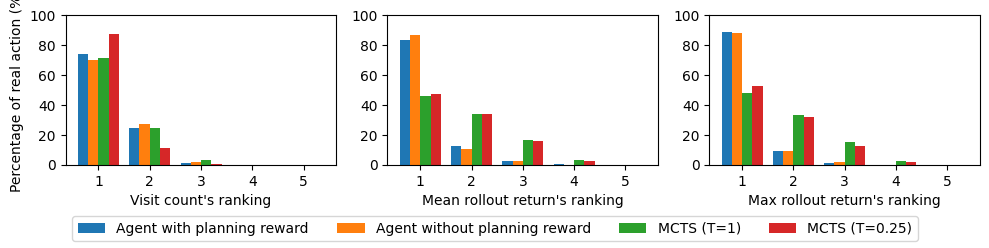

In [51]:
# real action analysis

from scipy.stats import rankdata
import matplotlib.pyplot as plt


def get_dataset(index="root_ns"):
    # base
    action = concat_d(real_stats_base["action"])
    x = concat_d(real_stats_base["model_stat"], index)
    rank_x = rankdata(x, axis=1, method="dense")
    rank_x = np.max(rank_x, axis=1)[:, np.newaxis] - rank_x
    chosen_x_base = rank_x[np.arange(x.shape[0]), action]

    # no planning reward
    action = concat_d(real_stats_noim["action"])
    x = concat_d(real_stats_noim["model_stat"], index)
    rank_x = rankdata(x, axis=1, method="dense")
    rank_x = np.max(rank_x, axis=1)[:, np.newaxis] - rank_x
    chosen_x_noim = rank_x[np.arange(x.shape[0]), action]

    # mcts
    chosen_x_mcts = []
    for temp in [1, 0.25]:
        x = np.concatenate(
            [
                concat_d(real_stats_base["model_stat"], "root_ns"),
                concat_d(real_stats_noim["model_stat"], "root_ns"),
            ]
        )
        n = x * 20
        if temp == -1:
            n_temp = n**0
        else:
            n_temp = n ** (1 / temp)
        p = n_temp / np.sum(n_temp, axis=-1)[:, np.newaxis]

        def sample_actions(probabilities):
            actions = []
            for prob in probabilities:
                action = np.random.choice(np.arange(len(prob)), p=prob)
                actions.append(action)
            return np.array(actions)

        x = np.concatenate(
            [
                concat_d(real_stats_base["model_stat"], index),
                concat_d(real_stats_noim["model_stat"], index),
            ]
        )
        action = sample_actions(p)
        rank_x = rankdata(x, axis=1, method="dense")
        rank_x = np.max(rank_x, axis=1)[:, np.newaxis] - rank_x
        chosen_x_mcts.append(rank_x[np.arange(x.shape[0]), action])

    return [chosen_x_base, chosen_x_noim] + chosen_x_mcts, [
        "Agent with planning reward",
        "Agent without planning reward",
        "MCTS (T=1)",
        "MCTS (T=0.25)",
    ]  # , "Random"]


datasets, labels = get_dataset(index="root_ns")
fig, axes = plt.subplots(1, 3, figsize=(20 / 2, 5 / 2))

plot_count(
    datasets=datasets,
    labels=labels,
    xlabel="Visit count's ranking",
    ylabel="Percentage of real action (%)",
    ax=axes[0],
    nolegend=True,
    ylim=[0, 100],
)

datasets, labels = get_dataset(index="root_qs_mean")
plot_count(
    datasets=datasets,
    labels=labels,
    xlabel="Mean rollout return's ranking",
    ylabel="",
    ax=axes[1],
    nolegend=True,
    ylim=[0, 100],
)

datasets, labels = get_dataset(index="root_qs_max")
plot_count(
    datasets=datasets,
    labels=labels,
    xlabel="Max rollout return's ranking",
    ylabel="",
    ax=axes[2],
    nolegend=True,
    ylim=[0, 100],
)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=5)

plt.tight_layout()
plt.subplots_adjust(
    bottom=0.32
)  # Adjust the bottom space so the legend does not overlap the plots
plt.savefig("/home/scuk/RS/thinker_paper/app_real.pdf", dpi=300, bbox_inches="tight")
plt.show()

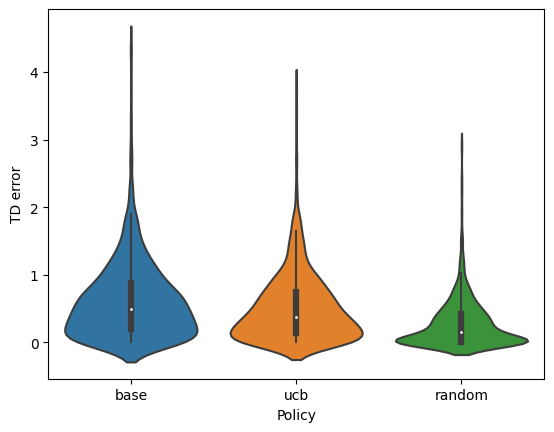

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame from your data
data = pd.DataFrame()

for k, n in max_qs.items():
    data[k] = pd.Series(n)

data_melted = data.melt(var_name="labels", value_name="TD error")

# Melt the DataFrame to a long format, which can be used with Seaborn
data_melted = data.melt(var_name="labels", value_name="TD error")

# Create a violin plot
sns.violinplot(x="labels", y="TD error", data=data_melted, scale="width")
plt.ylabel("TD error")
plt.xlabel("Policy")
plt.show()

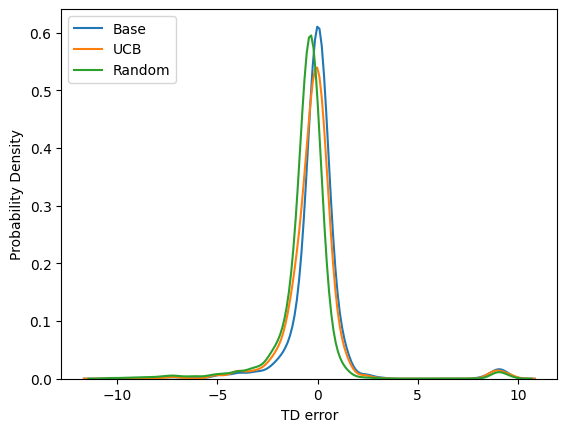

In [279]:
# unused, seems td error is not significant if the trajectory folloes imagained action output by the agent

batch_size = 10
all_stats = all_stats_base
n = len(all_stats["action"])

base_td_errs, random_td_errs, ucb_td_errs = [], [], []
for n in range(len(all_stats["action"])):
    action = all_stats["action"][n]
    model_stat = all_stats["model_stat"][n]
    expand_stat = all_stats["expand_stat"][n]
    ucb_action = ucb(model_stat)
    for m in range(batch_size):
        im_action = action[m, 1]
        reset = model_stat["reset"][m]
        real_step = model_stat["time"][m][-1] == 1
        if not reset and not real_step:
            sel_action = im_action
            new_root_trail_q = model_stat["root_trail_r"][m, 0] + model_stat["derec"][
                m, 0
            ] * (
                expand_stat[sel_action].rs[0, m]
                + 0.97 * expand_stat[sel_action].vs[0, m]
            )
            base_td_errs.append(
                (new_root_trail_q - model_stat["root_v"][m, 0]).cpu().numpy()
            )
            # root_max_v_change = torch.clamp(new_root_trail_q - model_stat["root_max_v"][m,0], min=0).cpu().numpy()
            # base_td_errs.append(root_max_v_change)

            sel_action = np.random.randint(5)
            new_root_trail_q = model_stat["root_trail_r"][m, 0] + model_stat["derec"][
                m, 0
            ] * (
                expand_stat[sel_action].rs[0, m]
                + 0.97 * expand_stat[sel_action].vs[0, m]
            )
            random_td_errs.append(
                (new_root_trail_q - model_stat["root_v"][m, 0]).cpu().numpy()
            )
            # root_max_v_change = torch.clamp(new_root_trail_q - model_stat["root_max_v"][m,0], min=0).cpu().numpy()
            # random_td_errs.append(root_max_v_change)

            sel_action = ucb_action[m]
            new_root_trail_q = model_stat["root_trail_r"][m, 0] + model_stat["derec"][
                m, 0
            ] * (
                expand_stat[sel_action].rs[0, m]
                + 0.97 * expand_stat[sel_action].vs[0, m]
            )
            ucb_td_errs.append(
                (new_root_trail_q - model_stat["root_v"][m, 0]).cpu().numpy()
            )
            # root_max_v_change = torch.clamp(new_root_trail_q - model_stat["root_max_v"][m,0], min=0).cpu().numpy()
            # ucb_td_errs.append(root_max_v_change)

base_td_errs = np.array(base_td_errs)
random_td_errs = np.array(random_td_errs)
ucb_td_errs = np.array(ucb_td_errs)


def plot_td(td_errs, labels):
    # Plot histograms
    for n in range(len(td_errs)):
        sns.kdeplot(td_errs[n], label=labels[n])
    # Setting the legend
    plt.legend(loc="upper left")
    plt.xlabel("TD error")
    plt.ylabel("Probability Density")
    # plt.yscale("log")
    # Show the plot
    plt.show()


# plot_td([base_td_errs, ucb_td_errs], labels=["Base", "UCB",])
plot_td([base_td_errs, ucb_td_errs, random_td_errs], labels=["Base", "UCB", "Random"])

In [90]:
# MCTS on trained model


def mcts_test(check_point_path, max_eps_n=200, batch_size=40, K=20, carry=False):
    device = torch.device("cuda")
    flags = util.parse(["--load_checkpoint", check_point_path])
    flags.rec_t = K
    flags.tree_carry = carry
    flags.max_depth = -1
    env = Environment(
        flags, env_n=batch_size, model_wrap=True, debug=True, device=device
    )
    num_actions = env.num_actions
    seed = np.arange(batch_size)
    env.seed(seed)
    model_net = ModelNet(
        obs_shape=env.gym_env_out_shape,
        num_actions=env.num_actions,
        flags=flags,
        debug=True,
    )
    model_net.train(False)

    model_path = os.path.join(check_point_path, "ckp_model.tar")
    checkpoint = torch.load(model_path, torch.device("cpu"))
    model_net.set_weights(
        checkpoint["model_state_dict"]
        if "model_state_dict" in checkpoint
        else checkpoint["model_net_state_dict"]
    )
    model_net.to(device)
    ret_buffer = RetBuffer(max_actor_id=batch_size, mean_n=max_eps_n - batch_size)

    with torch.no_grad():
        env_out = env.initial(model_net)
        while True:
            model_out = util.decode_model_out(
                env_out.model_out, num_actions, flags.model_enc_type
            )
            # real action
            temp = 0.25
            root_ns = torch.clone(model_out["root_ns"]) * flags.rec_t
            n_temp = root_ns ** (1 / temp) + 1e-7
            p = n_temp / torch.sum(n_temp, dim=-1, keepdim=True)
            real_action = torch.multinomial(p, num_samples=1)[:, 0]
            # imagainary action
            ucb_action = ucb(model_out, K=flags.rec_t)
            # print(ucb_action[0], model_out["root_ns"][0]*flags.rec_t)
            # reset action
            cur_ns = torch.clone(model_out["cur_ns"])
            cur_ns[model_out["reset"] == 1] = model_out["root_ns"][
                model_out["reset"] == 1
            ]
            reset = (torch.sum(cur_ns, dim=-1) <= 0).long()

            action = [
                real_action.unsqueeze(0),
                ucb_action.unsqueeze(0),
                reset.unsqueeze(0),
            ]

            action = torch.stack(action, dim=-1)
            env_out = env.step(action, model_net)

            if torch.any(env_out.real_done):
                ret_buffer.insert_raw(
                    env_out.episode_return,
                    ind=0,
                    actor_id=torch.arange(batch_size, device=device),
                    done=env_out.real_done,
                )
                # print("Avg. return: %.2f" %  ret_buffer.get_mean())

            if ret_buffer.all_filled:
                break
    return ret_buffer.return_buffer.reshape(-1)

In [91]:
check_point_path = "/home/scuk/logs/v13/v13_0.7b6_r2"
mcts_results = {}
Ks = [100]
# Ks = [2000]
for K in Ks:
    run = "%d_carry" % K
    mcts_results[run] = mcts_test(check_point_path, K=K, carry=True)
    print(
        "Finish %s, average return: %.2f; solved rate: %.2f"
        % (run, np.average(mcts_results[run]), np.average(mcts_results[run] > 5.0))
    )
    run = "%d_nocarry" % K
    mcts_results[run] = mcts_test(check_point_path, K=K, carry=False)
    print(
        "Finish %s, average return: %.2f; solved rate: %.2f"
        % (run, np.average(mcts_results[run]), np.average(mcts_results[run] > 5.0))
    )

Finish 100_carry, average return: 12.16; solved rate: 0.88
Finish 100_nocarry, average return: 12.05; solved rate: 0.87


Ablation Analysis

In [98]:
base_path = "/home/scuk/logs/v13"
runs = [
    "v13_0.7b6",
    "v13_0.7b6_r1",
    "v13_0.7b6_r2",
    "v13_b_0.7b6",
    "v13_b_0.7b6_r1",
    "v13_b_0.7b6_r2",
    "v13_b_drc_0.7b6",
    "v13_b_drc_0.7b6_r4",
    "v13_b_drc_0.7b6_r5",
    "v13_0.7b6_norew",
    "v13_0.7b6_nostat",
    "v13_0.7b6_nornn2b",
    # "v13_0.7b6_nornn_nostat",
    "v13_0.76b_norew_10L",
    # "v13_0.7b6_novpi",
    "v13_0.7b6_noimg",
    "v13_0.76b_norew_10L",
]
scores_sokoban = {}
for run in runs:
    scores_sokoban[run] = read_run(base_path, run, mean_n=200, tran=True)

Reading v13_0.7b6 max_actor_id 64
Reading v13_0.7b6_r1 max_actor_id 64
Reading v13_0.7b6_r2 max_actor_id 64
Reading v13_b_0.7b6 max_actor_id 128
Reading v13_b_0.7b6_r1 max_actor_id 128
Reading v13_b_0.7b6_r2 max_actor_id 128
Reading v13_b_drc_0.7b6 max_actor_id 128
Reading v13_b_drc_0.7b6_r4 max_actor_id 128
Reading v13_b_drc_0.7b6_r5 max_actor_id 128
Reading v13_0.7b6_norew max_actor_id 64
Reading v13_0.7b6_nostat max_actor_id 64
Reading v13_0.7b6_nornn2b max_actor_id 64
Reading v13_0.76b_norew_10L max_actor_id 64
Reading v13_0.7b6_noimg max_actor_id 64
Reading v13_0.76b_norew_10L max_actor_id 64


<Axes: xlabel='Frames', ylabel='Solving Rate'>

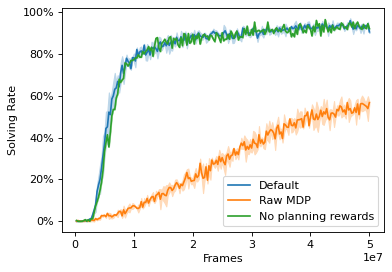

In [106]:
results = {
    "Default": ["v13_0.7b6", "v13_0.7b6_r1", "v13_0.7b6_r2"],
    "Raw MDP": ["v13_b_0.7b6", "v13_b_0.7b6_r1", "v13_b_0.7b6_r2"],
    "No planning rewards": ["v13_0.7b6_norew"],
}
saveimg = "/home/scuk/RS/thinker_paper/app_ab_1.pdf"

xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []
    for r in rs:
        y.append(scores_sokoban[r][1])
    ys.append(np.array(y))
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)

plot(xs, ys, labels, saveimg=saveimg)

<Axes: xlabel='Frames', ylabel='Solving Rate'>

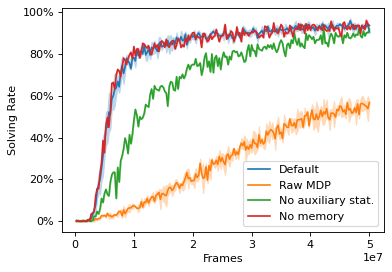

In [116]:
results = {
    "Default": ["v13_0.7b6", "v13_0.7b6_r1", "v13_0.7b6_r2"],
    "Raw MDP": ["v13_b_0.7b6", "v13_b_0.7b6_r1", "v13_b_0.7b6_r2"],
    "No auxiliary stat.": ["v13_0.7b6_nostat"],
    "No memory": ["v13_0.7b6_nornn2b"],
    # "No auxilary stat. & memory":["v13_0.7b6_nornn2b"]
}
saveimg = "/home/scuk/RS/thinker_paper/app_ab_2.pdf"

xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []
    for r in rs:
        y.append(scores_sokoban[r][1])
    ys.append(np.array(y))
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)

plot(xs, ys, labels, saveimg=saveimg)

<Axes: xlabel='Frames', ylabel='Solving Rate'>

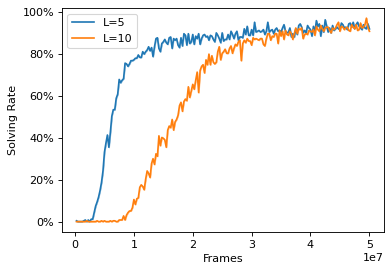

In [108]:
results = {
    "L=5": ["v13_0.7b6_norew"],
    "L=10": ["v13_0.76b_norew_10L"],
}
saveimg = "/home/scuk/RS/thinker_paper/app_ab_3.pdf"

xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []
    for r in rs:
        y.append(scores_sokoban[r][1])
    ys.append(np.array(y))
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)

plot(xs, ys, labels, saveimg=saveimg)

<Axes: xlabel='Frames', ylabel='Solving Rate'>

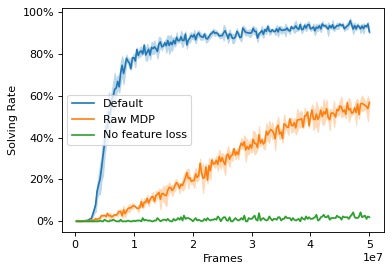

In [109]:
results = {
    "Default": ["v13_0.7b6", "v13_0.7b6_r1", "v13_0.7b6_r2"],
    "Raw MDP": ["v13_b_0.7b6", "v13_b_0.7b6_r1", "v13_b_0.7b6_r2"],
    # "No values & policies":["v13_0.7b6_nornn2b"],
    "No feature loss": ["v13_0.7b6_noimg"],
}
saveimg = "/home/scuk/RS/thinker_paper/app_ab_4.pdf"

xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []
    for r in rs:
        y.append(scores_sokoban[r][1])
    ys.append(np.array(y))
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)

plot(xs, ys, labels, saveimg=saveimg)

Past Experiments

In [6]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath("thinker/thinker")
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from collections import deque
import time
import numpy as np
import copy
import argparse
import torch
import torch.nn.functional as F
from thinker.env import Environment
from thinker.net import ActorNet, ModelNet
import gym
import thinker.util as util
from visual import *

%matplotlib inline


def load_env_model(check_point_path, seed=1):
    checkpoint = torch.load(
        os.path.join(check_point_path, "ckp_model.tar"), torch.device("cpu")
    )
    flags = util.parse(["--load_checkpoint", check_point_path])
    flags.actor_see_type = 0
    flags_ = copy.deepcopy(flags)

    # flags_.actor_see_p = 1
    # flags_.actor_see_encode = True
    # flags_.actor_see_h = True
    # flags_.max_depth = 20
    env = Environment(flags_, model_wrap=True)

    env.seed([seed])
    num_actions = env.num_actions

    flags_ = copy.deepcopy(flags)
    flags_.perfect_model = True
    # flags_.actor_see_p = 1
    # flags_.max_depth = 20
    perfect_env = Environment(flags_, model_wrap=True)
    perfect_env.seed([seed])

    model_net = ModelNet(
        obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags
    )
    model_net.train(False)
    model_net.set_weights(
        checkpoint["model_state_dict"]
        if "model_state_dict" in checkpoint
        else checkpoint["model_net_state_dict"]
    )

    env_out = env.initial(model_net)
    perfect_env_out = perfect_env.initial(model_net)

    util.decode_model_out(env_out.model_out, num_actions, True)
    # plot_gym_env_out(env_out.gym_env_out.squeeze(0))
    # _ = decode(model_net, env_out, visualize=True)

    return model_net, env, perfect_env, env_out, perfect_env_out, flags


def step_reals(actions, env, perfect_env, model_net, flags):
    for a in actions:
        while True:
            action = torch.tensor([[[a, 0, 0]]], dtype=torch.long)
            env_out = env.step(action, model_net)
            perfect_env_out = perfect_env.step(action, model_net)
            sp = torch.sum(torch.abs(env_out.model_encodes) < 1e-4) / (
                torch.numel(env_out.model_encodes)
            )
            if env_out.cur_t[0, 0] == 0:
                break
    return env_out, perfect_env_out, sp


def tb_out(model_net_out):
    d = {}
    for k in model_net_out._fields:
        if type(getattr(model_net_out, k)) == torch.Tensor:
            d[k] = getattr(model_net_out, k).squeeze(0).unsqueeze(1)
    return util.construct_tuple(type(model_net_out), **d)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


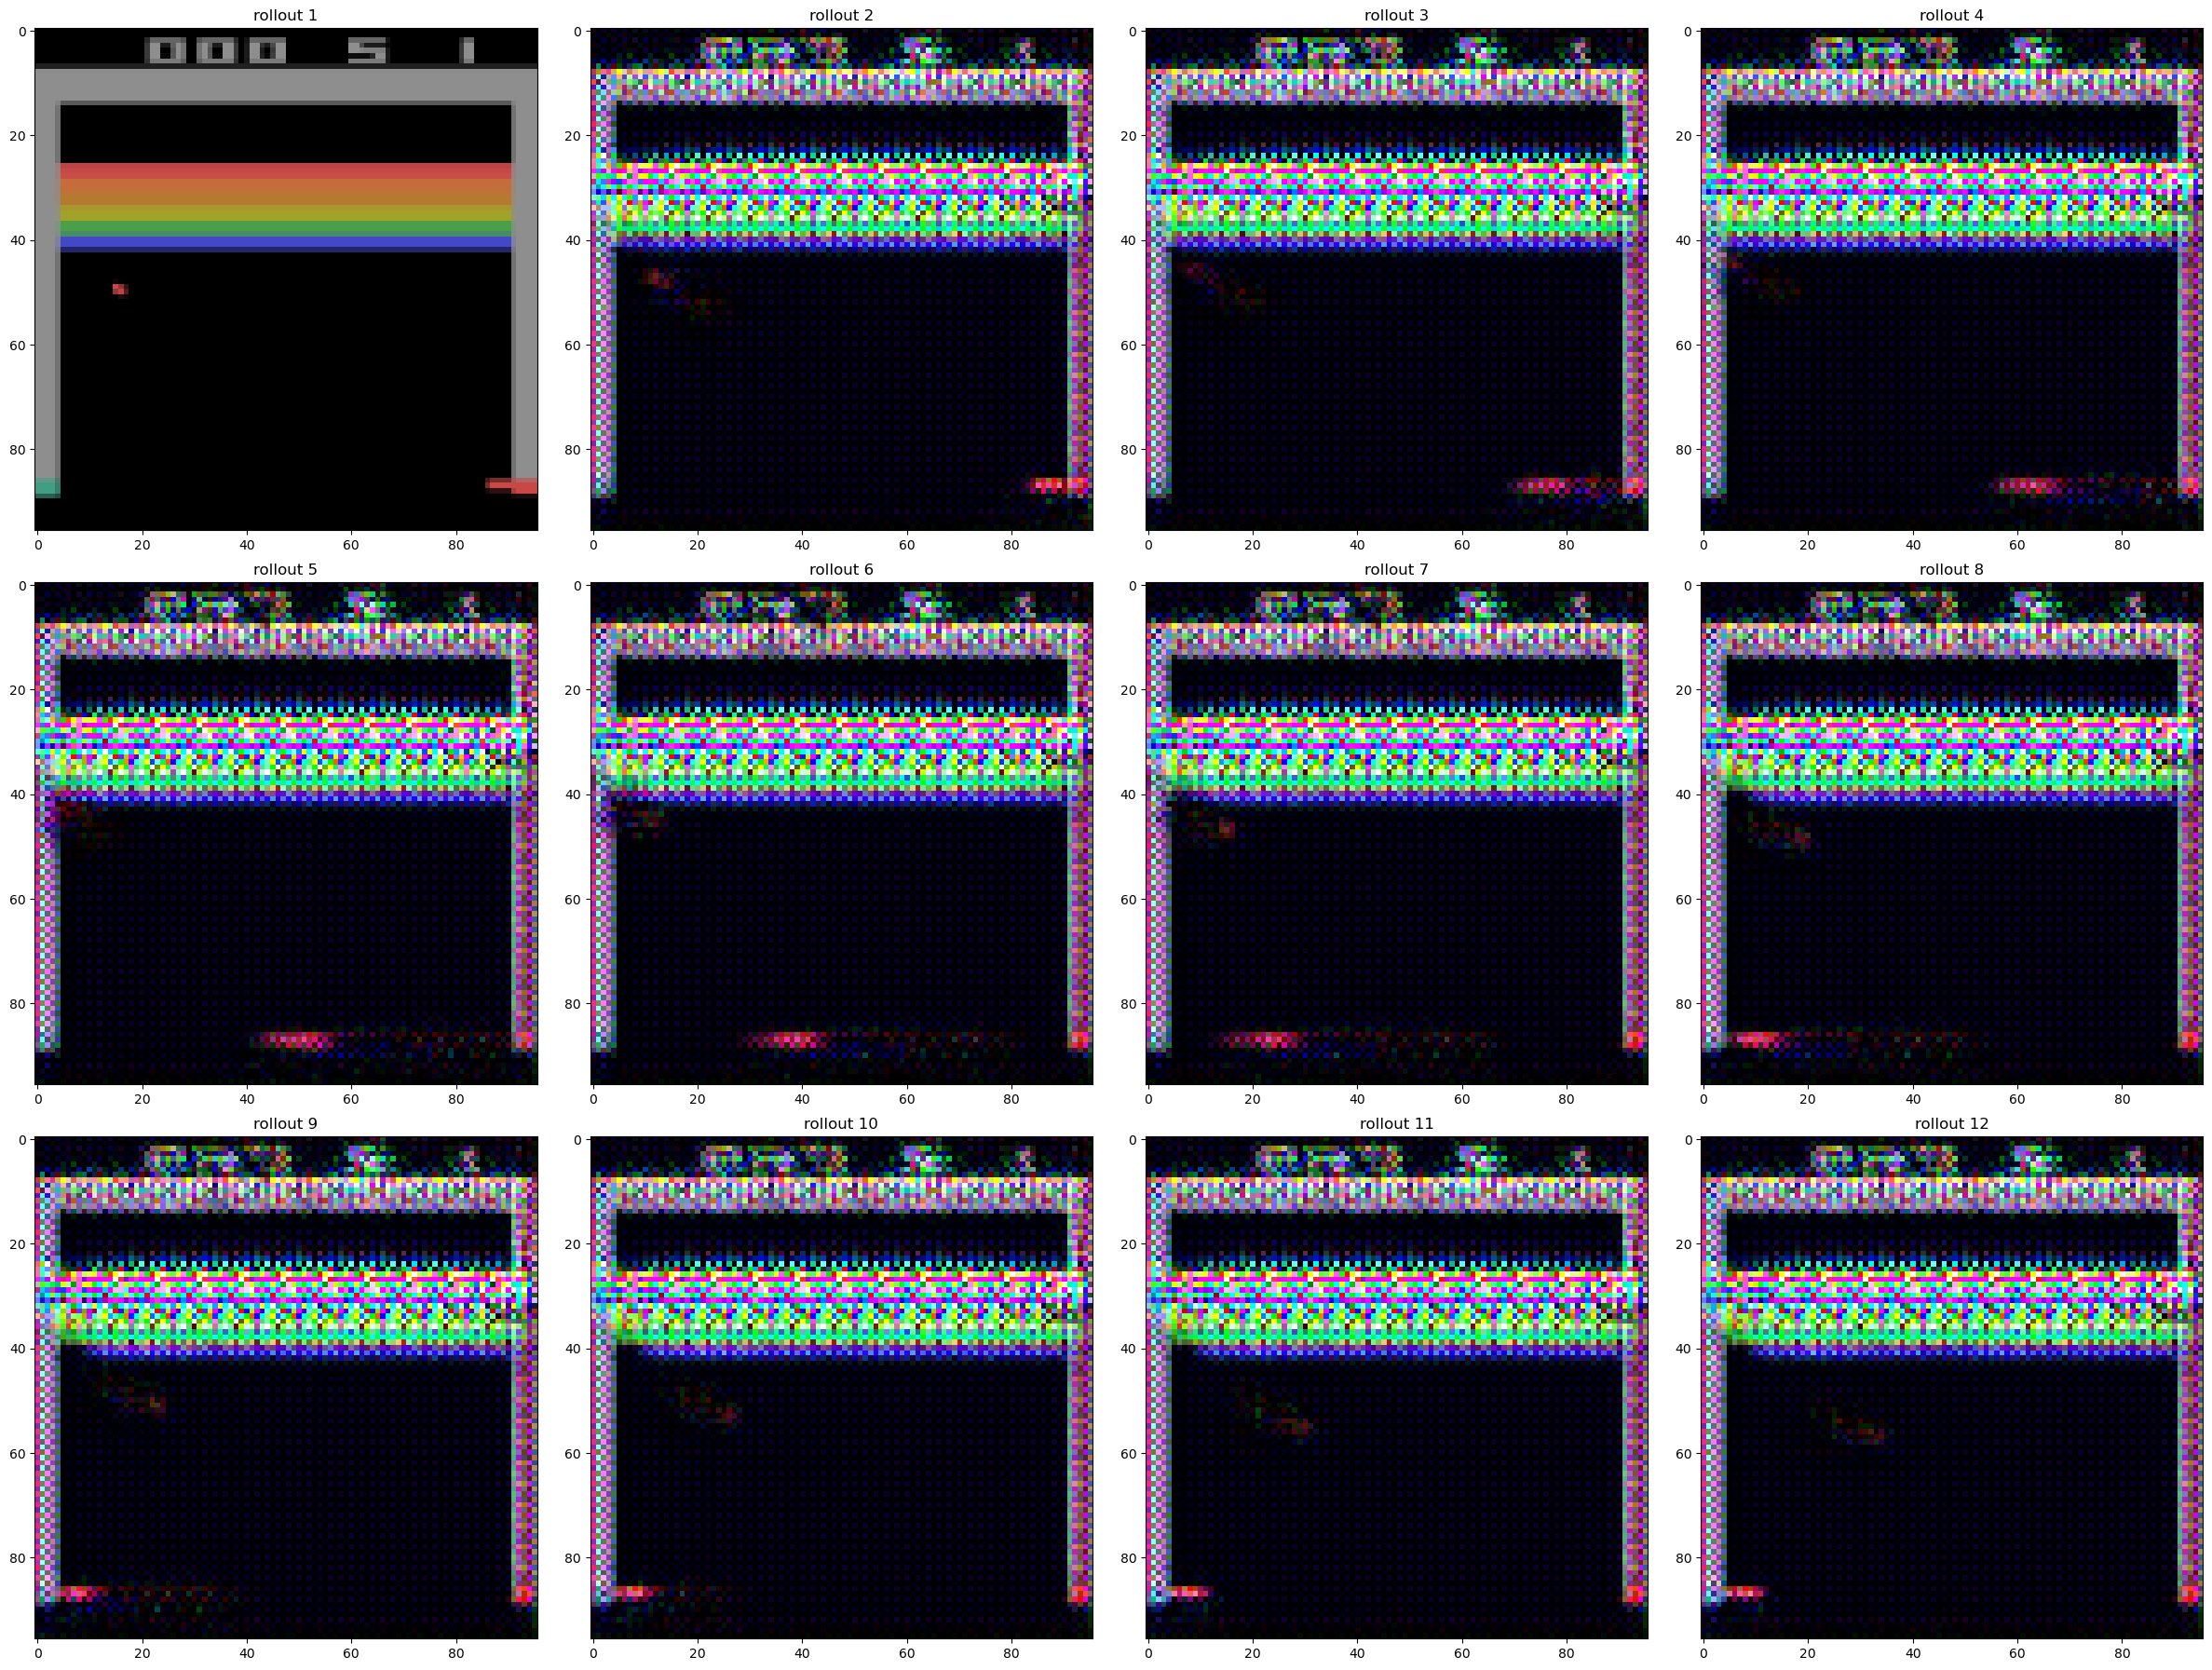

In [11]:
# check_point_path = '/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_duel_net_100_imgc_done_g/'
# check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/v2_duel_net_10_imgc_done'
# check_point_path = '/media/sc/datadisk/data/thinker/logs/v7/v7_duel_net_1img_type'
check_point_path = (
    "/media/sc/datadisk/data/thinker/logs/breakout_v2/v2_duel_net_1img_type_b/"
)
model_net, env, perfect_env, env_out, perfect_env_out, flags = load_env_model(
    check_point_path, seed=1
)

actions = [
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
    2,
]
env_out, perfect_env_out, sp = step_reals(actions, env, perfect_env, model_net, flags)

# actions = np.random.randint(low=0, high=5, size=(6))
# actions = [3,3,3,3,4,4,4,2]
actions = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
actions = torch.tensor(actions).unsqueeze(-1)
# model_net_out = model_net(env_out.gym_env_out, actions=actions, one_hot=False, compute_true_z=False, inference=True)
model_net_out = model_net(env_out.gym_env_out[0], actions=actions, one_hot=False)
pred_xs = torch.concat([model_net_out.ys], dim=0)
# pred_xs = torch.concat([env_out.gym_env_out[[0]].float()/255., model_net_out.pred_xs], dim=0)
plot_env_outs = np.clip(pred_xs[:, 0].detach().cpu().numpy() * 255, 0, 255)
_ = plot_multi_gym_env_out(plot_env_outs, titles=None, col_n=4)

In [ ]:
# See what the model learns

# check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/value_prefix/'
# check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/supervise_8'
# check_point_path = '/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_l2_loss_sep_zh_d'
# check_point_path = '/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_img_loss_0.01'
# check_point_path = '/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_cos_loss_sep_zh_b'
check_point_path = (
    "/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_duel_net_100_imgc_done_g"
)
# check_point_path = '/media/sc/datadisk/data/thinker/logs/breakout_v2/v2_duel_net_10_imgc_done'
check_point_path = "/media/sc/datadisk/data/thinker/logs/v7/v7_duel_net_1img_type"
check_point_path = os.path.expanduser(check_point_path)
model_net, env, perfect_env, env_out, perfect_env_out, flags = load_env_model(
    check_point_path
)
num_actions = env.num_actions

actions = [
    4,
    2,
    3,
    3,
    2,
    3,
    1,
    4,
    4,
    4,
    4,
    1,
    4,
    4,
    4,
    2,
    2,
    3,
    3,
    3,
    4,
    1,
    2,
    2,
    4,
    4,
    4,
    1,
    1,
    3,
    3,
    3,
    3,
    3,
    3,
    4,
    4,
    4,
    4,
    4,
    4,
    4,
    4,
    2,
    3,
]
env_out, perfect_env_out, sp = step_reals(actions, env, perfect_env, model_net, flags)

# im_actions = [2 for _ in range(20)]
# im_actions = [3,2,2,3,2,2,2,2]
im_actions = [3, 3, 3, 3, 3, 2, 4, 1, 2, 3, 4]
model_outs, perfect_model_outs = {}, {}
gym_env_outs = []
rec_env_outs = []


def print_info(n, env_out, perfect_env_out, num_actions):
    model_out = util.decode_model_out(env_out.model_out, num_actions, True)
    perfect_model_out = util.decode_model_out(
        perfect_env_out.model_out, num_actions, True
    )
    sp = torch.sum(torch.abs(env_out.model_encodes) < 1e-4) / (
        torch.numel(env_out.model_encodes)
    )
    # z_diff = torch.mean(torch.square(env_out.model_encodes - perfect_env_out.model_encodes))
    z_diff = torch.mean(torch.square(model_out["raw"] - perfect_model_out["raw"]))
    # z_diff = 0.
    print(
        (
            "step: %d; z_diff %f, im reward: %f (p: %f) root_v: %f (p: %f) max_v: %f (p: %f)"
            + "trail_q:%f (p: %f) max_q: %f (p: %f) mean_q: %f (p: %f) sparsity: %f"
        )
        % (
            n,
            z_diff,
            env_out.reward[0, 0, 1],
            perfect_env_out.reward[0, 0, 1],
            model_out["root_v"],
            perfect_model_out["root_v"],
            model_out["root_max_v"],
            perfect_model_out["root_max_v"],
            model_out["root_trail_q"],
            perfect_model_out["root_trail_q"],
            torch.max(model_out["root_qs_max"]),
            torch.max(perfect_model_out["root_qs_max"]),
            torch.mean(model_out["root_qs_mean"]),
            torch.mean(perfect_model_out["root_qs_mean"]),
            sp,
        )
    )


def decode(model_net, env_out, visualize):
    model_encodes = env_out.model_encodes
    if model_net.flags.duel_net:
        rec_env_out = model_encodes.squeeze(0)
    else:
        return None
    rec_env_out = rec_env_out.squeeze(0).detach()
    rec_env_out = (torch.clip(rec_env_out, 0, 1) * 255).int()
    if visualize:
        plot_gym_env_out(rec_env_out.unsqueeze(0))
    return rec_env_out


print_info(0, env_out, perfect_env_out, num_actions)
for n, im_action in enumerate(im_actions):
    action = torch.tensor([[[0, im_action, 0]]], dtype=torch.long)
    env_out = env.step(action, model_net)
    model_out = util.decode_model_out(env_out.model_out, num_actions, True)
    perfect_env_out = perfect_env.step(action, model_net)
    perfect_model_out = util.decode_model_out(
        perfect_env_out.model_out, num_actions, True
    )

    gym_env_outs.append(perfect_env_out.gym_env_out.squeeze(0).squeeze(0))
    rec_env_out = decode(model_net, env_out, visualize=False)
    if rec_env_out is not None:
        rec_env_outs.append(rec_env_out)

    # pred_encodes = model_net.frameEncoder(rec_env_out.unsqueeze(0), F.one_hot(action[0, :, 1], num_classes=5))[0]
    # z_diff = torch.mean(torch.abs(pred_encodes - perfect_env_out.model_encodes))
    # print(z_diff)

    print_info(n + 1, env_out, perfect_env_out, num_actions)
    # assert torch.all(model_out["root_logits"] == perfect_model_out["root_logits"])

    for outs, out in [[model_outs, model_out], [perfect_model_outs, perfect_model_out]]:
        for k, v in out.items():
            if k not in outs:
                outs[k] = [v]
            else:
                outs[k].append(v)

titles = []
plot_env_outs = []
for n in range(len(model_outs["cur_r"])):
    titles.append(
        "t:%d, r:%.2f,v:%.2f;pred-r:%.2f v:%.2f"
        % (
            n + 1,
            perfect_model_outs["cur_r"][n],
            perfect_model_outs["cur_v"][n],
            model_outs["cur_r"][n],
            model_outs["cur_v"][n],
        )
    )
    plot_env_outs.append(gym_env_outs[n])
    if len(rec_env_outs) > 0:
        l2_loss = torch.mean(
            torch.square((rec_env_outs[n] - gym_env_outs[n]).float() / 255.0)
        )
        titles.append("t:%d loss:%f" % (n + 1, l2_loss))
        plot_env_outs.append(rec_env_outs[n])


fig = plot_multi_gym_env_out(plot_env_outs, titles=titles, col_n=4)
plt.show()

In [ ]:
flags = util.parse(["--load_checkpoint", check_point_path])
env = Environment(flags, model_wrap=False)
env_out = env.initial()
xs = [env_out.gym_env_out]
actions = [0, 1, 1, 2, 2]
for a in actions[1:]:
    a = torch.tensor(a, dtype=torch.long).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    env_out = env.step(a)
    xs.append(env_out.gym_env_out)

xs = torch.concat(xs, dim=0)
actions = torch.tensor(actions, dtype=torch.long).unsqueeze(-1)
model_net_out = model_net(
    xs, actions=actions, compute_true_z=True, one_hot=False, inference=False
)
print(
    "zs L2 error: %f"
    % torch.mean(torch.square(model_net_out.true_zs[1:] - model_net_out.pred_zs[1:]))
)

perfect_model_net_out = tb_out(
    model_net(
        xs.flatten(0, 1).unsqueeze(0), actions.flatten(0, 1).unsqueeze(0), one_hot=False
    )
)

print(
    "zs L2 error: %f"
    % torch.mean(
        torch.square(perfect_model_net_out.true_zs[1:] - model_net_out.pred_zs[1:])
    )
)
print(
    "logit error: %f"
    % torch.mean(torch.square(perfect_model_net_out.logits - model_net_out.logits))
)
print(
    "v error: %f"
    % torch.mean(torch.square(perfect_model_net_out.vs - model_net_out.vs))
)

In [3]:
import os
import sys
from collections import deque
import time
import numpy as np
import copy
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import torch
import torch.nn.functional as F
from thinker.env import Environment
from thinker.net import ActorNet, ModelNet
import thinker.util as util
import gym


def plot_gym_env_out(x, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(
        torch.swapaxes(torch.swapaxes(x[0, -3:].cpu(), 0, 2), 0, 1),
        interpolation="nearest",
        aspect="auto",
    )
    if title is not None:
        ax.set_title(title)


def plot_multi_gym_env_out(xs, titles=None, col_n=5):
    size_n = 6
    row_n = (len(xs) + (col_n - 1)) // col_n

    fig, axs = plt.subplots(row_n, col_n, figsize=(col_n * size_n, row_n * size_n))
    if len(axs.shape) == 1:
        axs = axs[np.newaxis, :]
    m = 0
    for y in range(row_n):
        for x in range(col_n):
            if m >= len(xs):
                axs[y][x].set_axis_off()
            else:
                axs[y][x].imshow(np.transpose(xs[m][-3:], axes=(1, 2, 0)) / 255)
                axs[y][x].set_title(
                    "rollout %d" % (m + 1) if titles is None else titles[m]
                )
            m += 1
    plt.tight_layout()
    return fig


def plot_policies(logits, labels, action_meanings, ax=None, title="Real policy prob"):
    if ax is None:
        fig, ax = plt.subplots()
    probs = []
    for logit, k in zip(logits, labels):
        if k != "action":
            probs.append(torch.softmax(logit, dim=-1).detach().cpu().numpy())
        else:
            probs.append(logit.detach().cpu().numpy())

    ax.set_title(title)
    xs = np.arange(len(probs[0]))
    for n, (prob, label) in enumerate(zip(probs, labels)):
        ax.bar(xs + 0.1 * (n - len(logits) // 2), prob, width=0.1, label=label)
    ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(len(probs[0]))))
    ax.set_xticklabels(action_meanings)
    ax.set_ylim(0, 1)
    ax.legend()


def plot_base_policies(logits, action_meanings, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    prob = torch.softmax(logits, dim=-1).detach().cpu().numpy()
    rec_t, num_actions = logits.shape
    xs = np.arange(rec_t)
    labels = action_meanings
    for i in range(num_actions):
        c = ax.bar(
            xs + 0.8 * (i / num_actions),
            prob[:, i],
            width=0.8 / (num_actions),
            label=labels[i],
        )
        color = c.patches[0].get_facecolor()
        color = color[:3] + (color[3] * 0.5,)
        ax.bar(
            xs + 0.8 * (i / num_actions),
            prob[:, i],
            width=0.8 / (num_actions),
            color=color,
        )
    ax.legend()
    ax.set_ylim(0, 1)
    ax.set_title("Model policy prob")


def plot_im_policies(
    im_policy_logits,
    reset_policy_logits,
    im_action,
    reset_action,
    action_meanings,
    one_hot=True,
    reset_ind=0,
    ax=None,
):
    if ax is None:
        fig, ax = plt.subplots()

    rec_t, num_actions = im_policy_logits.shape
    num_actions += 1
    rec_t -= 1

    im_prob = torch.softmax(im_policy_logits, dim=-1).detach().cpu().numpy()
    reset_prob = (
        torch.softmax(reset_policy_logits, dim=-1)[:, [reset_ind]]
        .detach()
        .cpu()
        .numpy()
    )
    full_prob = np.concatenate([im_prob, reset_prob], axis=-1)

    if not one_hot:
        im_action = F.one_hot(im_action, num_actions - 1)
    im_action = im_action.detach().cpu().numpy()
    reset_action = reset_action.unsqueeze(-1).detach().cpu().numpy()
    full_action = np.concatenate([im_action, reset_action], axis=-1)

    xs = np.arange(rec_t + 1)
    labels = action_meanings.copy()
    labels.append("RESET")

    for i in range(num_actions):
        c = ax.bar(
            xs + 0.8 * (i / num_actions),
            full_prob[:, i],
            width=0.8 / (num_actions),
            label=labels[i],
        )
        color = c.patches[0].get_facecolor()
        color = color[:3] + (color[3] * 0.5,)
        ax.bar(
            xs + 0.8 * (i / num_actions),
            full_action[:, i],
            width=0.8 / (num_actions),
            color=color,
        )

    ax.legend()
    ax.set_ylim(0, 1)
    ax.set_title("Imagainary policy prob")


def plot_qn_sa(q_s_a, n_s_a, action_meanings, max_q_s_a=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    xs = np.arange(len(q_s_a))

    ax.bar(xs - 0.3, q_s_a.cpu(), color="g", width=0.3, label="q_s_a")
    ax_n = ax.twinx()
    if max_q_s_a is not None:
        ax.bar(xs, max_q_s_a.cpu(), color="r", width=0.3, label="max_q_s_a")
    ax_n.bar(
        xs + (0.3 if max_q_s_a is not None else 0.0),
        n_s_a.cpu(),
        bottom=0,
        color="b",
        width=0.3,
        label="n_s_a",
    )
    ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(len(q_s_a))))
    ax.set_xticklabels(action_meanings)
    ax.legend(loc="lower left")
    ax_n.legend(loc="lower right")
    ax.set_title("q_s_a and n_s_a")


def gen_video(video_stats, file_path):
    import cv2

    # Generate video
    imgs = []
    hw = video_stats["real_imgs"][0].shape[1]

    for i in range(len(video_stats["real_imgs"])):
        img = np.zeros(shape=(hw, hw * 2, 3), dtype=np.uint8)
        real_img = np.copy(video_stats["real_imgs"][i])
        real_img = np.swapaxes(np.swapaxes(real_img, 0, 2), 0, 1)
        im_img = np.copy(video_stats["im_imgs"][i])
        im_img = np.swapaxes(np.swapaxes(im_img, 0, 2), 0, 1)
        if video_stats["status"][i] == 1:
            im_img[:, :, 0] = 255 * 0.3 + im_img[:, :, 0] * 0.7
            im_img[:, :, 1] = 255 * 0.3 + im_img[:, :, 1] * 0.7
        elif video_stats["status"][i] == 0:
            im_img[:, :, 2] = 255 * 0.3 + im_img[:, :, 2] * 0.7
        img[:, :hw, :] = real_img
        img[:, hw:, :] = im_img
        img = np.flip(img, 2)
        imgs.append(img)

    width = hw * 2
    height = hw
    fps = 5

    path = os.path.join(file_path, "video.mjpg")
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    video = cv2.VideoWriter(path, fourcc, float(fps), (width, height))
    video.set(cv2.CAP_PROP_BITRATE, 10000)  # set the video bitrate to 10000 kb/s
    for img in imgs:
        video.write(img)
    video.release()


def print_im_actions(im_dict, action_meanings, print_stat=False):
    lookup_dict = {k: v for k, v in enumerate(action_meanings)}
    print_strs = []
    n, s = 1, ""
    reset = False
    for im, reset in zip(im_dict["im_action"][:-1], im_dict["reset_action"][:-1]):
        s += lookup_dict[im.item()] + ", "
        if reset:
            s += "Reset"
            print_strs.append("%d: %s" % (n, s))
            s = ""
            n += 1
    if not reset:
        print_strs.append("%d: %s" % (n, s[:-2]))
    if print_stat:
        for s in print_strs:
            print(s)
    return print_strs


saveimg = True
model_path = ""
check_point_path = (
    "/media/sc/datadisk/data/thinker/logs/v7/v7_duel_net_1img_type_rnorm/"
)
visualize = False

max_eps_n = 1
saveimg_dir = "/home/sc/RS/thinker/test/data/"

flags = util.parse(["--load_checkpoint", check_point_path])
# flags.actor_net_ver = 0
name = "%s-%s" % (flags.xpid, time.strftime("%Y%m%d-%H%M%S"))

if saveimg:
    saveimg_a = os.path.join(saveimg_dir, name, "a")
    saveimg_b = os.path.join(saveimg_dir, name, "b")
    if not (os.path.exists(saveimg_a)):
        os.makedirs(saveimg_a)
    if not (os.path.exists(saveimg_b)):
        os.makedirs(saveimg_b)
    print("saving images to %s" % (os.path.join(saveimg_dir, name)))
    savef = open(os.path.join(saveimg_dir, name, "logs.txt"), "a")
env = Environment(flags, model_wrap=True, debug=True)
if not flags.perfect_model:
    flags_ = copy.deepcopy(flags)
    flags_.perfect_model = True
    flags_.actor_see_p = 1
    perfect_env = Environment(flags_, model_wrap=True)

if flags.env == "cSokoban-v0" or flags.env == "Sokoban-v0":
    action_meanings = ["NOOP", "UP", "DOWN", "LEFT", "RIGHT"]
else:
    action_meanings = gym.make(flags.env).get_action_meanings()
num_actions = env.num_actions

env.seed([0])
if not flags.perfect_model:
    perfect_env.seed([0])

model_net = ModelNet(
    obs_shape=env.gym_env_out_shape,
    num_actions=env.num_actions,
    flags=flags,
    debug=True,
)
model_net.train(False)
if not model_path:
    model_path = os.path.join(check_point_path, "ckp_model.tar")
checkpoint = torch.load(model_path, torch.device("cpu"))
model_net.set_weights(
    checkpoint["model_state_dict"]
    if "model_state_dict" in checkpoint
    else checkpoint["model_net_state_dict"]
)

actor_net = ActorNet(
    obs_shape=env.model_out_shape,
    gym_obs_shape=env.gym_env_out_shape,
    num_actions=env.num_actions,
    flags=flags,
)
checkpoint = torch.load(
    os.path.join(check_point_path, "ckp_actor.tar"), torch.device("cpu")
)
actor_net.set_weights(checkpoint["actor_net_state_dict"])
actor_state = actor_net.initial_state(batch_size=1)

env_out = env.initial(model_net)
if not flags.perfect_model:
    perfect_env_out = perfect_env.initial(model_net)
    assert torch.all(env_out.gym_env_out == perfect_env_out.gym_env_out)

gym_env_out_ = env_out.gym_env_out
model_out = util.decode_model_out(
    env_out.model_out, num_actions, flags.reward_transform
)
end_gym_env_outs, end_titles = [], []
ini_max_q = model_out["root_max_v"][0].item()

step = 0
returns, model_logits, attn_output = (
    [],
    [],
    [],
)
im_list = ["im_policy_logits", "reset_policy_logits", "im_action", "reset_action"]
im_dict = {k: [] for k in im_list}

video_stats = {"real_imgs": [], "im_imgs": [], "status": []}
video_stats["real_imgs"].append(env_out.gym_env_out[0, 0, -3:].numpy())
video_stats["im_imgs"].append(video_stats["real_imgs"][-1])
video_stats["status"].append(0)  # 0 for real step, 1 for reset, 2 for normal

while len(returns) < max_eps_n:
    step += 1
    actor_out, actor_state = actor_net(env_out, actor_state)

    if env_out.cur_t[0, 0] == 0:
        agent_v = actor_out.baseline[0, 0, 0]
    action = [actor_out.action, actor_out.im_action, actor_out.reset_action]
    action = torch.cat(action, dim=-1).unsqueeze(0)

    # additional stat record
    for k in im_list:
        im_dict[k].append(
            getattr(actor_out, k)[:, 0]
            if k in actor_out._fields and getattr(actor_out, k) is not None
            else None
        )
    # attn_output.append(torch.cat([x.attn_output_weights.unsqueeze(0).unsqueeze(-2) for x in actor_net.core.layers])[:, :, 0, :])

    model_out_ = util.decode_model_out(
        env_out.model_out, num_actions, flags.reward_transform
    )
    model_logits.append(model_out_["cur_logits"])
    env_out = env.step(action, model_net)
    model_out = util.decode_model_out(
        env_out.model_out, num_actions, flags.reward_transform
    )
    if len(im_dict["reset_action"]) > 0:
        im_dict["reset_action"][-1] = model_out["reset"]
    if not flags.perfect_model:
        perfect_env_out = perfect_env.step(action, model_net)
    # gym_env_out = env_out.gym_env_out if flags.perfect_model else perfect_env_out.gym_env_out
    gym_env_out = (torch.clamp(env.env.xs, 0, 1) * 255).to(torch.uint8)
    if not flags.perfect_model:
        perfect_model_out = util.decode_model_out(
            perfect_env_out.model_out, num_actions, flags.reward_transform
        )

    if model_out["reset"] == 1 or env_out.cur_t[0, 0] == flags.rec_t - 1:
        title = "pred v: %.2f" % (model_out["cur_v"].item())
        if not flags.perfect_model:
            title += " v: %.2f" % (perfect_model_out["cur_v"].item())
        end_gym_env_outs.append(gym_env_out[0, 0].numpy())
        end_titles.append(title)

    if not flags.perfect_model and env_out.cur_t[0, 0] == 0:
        assert torch.all(env_out.gym_env_out == perfect_env_out.gym_env_out)

    # record data for generating video
    if action[0, 0, 2] == 1:
        video_stats["real_imgs"].append(video_stats["real_imgs"][-1])
        video_stats["im_imgs"].append(video_stats["real_imgs"][-1])
        video_stats["status"].append(1)

    if env_out.cur_t[0, 0] == 0:
        video_stats["real_imgs"].append(gym_env_out[0, 0, -3:].numpy())
        video_stats["status"].append(0)
    else:
        video_stats["real_imgs"].append(video_stats["real_imgs"][-1])
        video_stats["status"].append(2)
    video_stats["im_imgs"].append(gym_env_out[0, 0, -3:].numpy())

    # visualize when a real step is made
    if (saveimg or visualize) and env_out.cur_t[0, 0] == 0:
        fig, axs = plt.subplots(1, 5, figsize=(30, 6))
        title = "%d; v: %.2f (%.2f)" % (step, model_out_["root_v"][0], agent_v)
        title += " max_q: %.2f ini_max_q: %.2f mean_q_0: %.2f" % (
            model_out_["root_max_v"][0].item(),
            ini_max_q,
            env.env.baseline_mean_q[0],
        )
        for k in im_list:
            if im_dict[k][0] is not None:
                im_dict[k] = torch.concat(im_dict[k], dim=0)
            else:
                im_dict[k] = None

        if flags.reward_type == 1:
            title += " im_return: %.4f" % env_out.episode_return[..., 1]
        plot_gym_env_out(gym_env_out_[0], axs[0], title=title)
        plot_base_policies(
            torch.concat(model_logits), action_meanings=action_meanings, ax=axs[1]
        )
        plot_im_policies(
            **im_dict,
            action_meanings=action_meanings,
            one_hot=False,
            reset_ind=1,
            ax=axs[2]
        )

        mean_q_s_a = model_out_["root_qs_mean"][0]
        max_q_s_a = model_out_["root_qs_max"][0]
        n_s_a = model_out_["root_ns"][0]
        plot_qn_sa(
            mean_q_s_a,
            n_s_a,
            action_meanings=action_meanings,
            max_q_s_a=max_q_s_a,
            ax=axs[3],
        )

        model_policy_logits = model_out_["root_logits"][0]
        agent_policy_logits = actor_out.policy_logits[0, 0]
        action = torch.nn.functional.one_hot(actor_out.action[0, 0], env.num_actions)
        plot_policies(
            [model_policy_logits, agent_policy_logits, action],
            ["model policy", "agent policy", "action"],
            action_meanings=action_meanings,
            ax=axs[4],
        )

        if saveimg:
            plt.savefig(os.path.join(saveimg_a, "%d.png" % step))
        if visualize:
            plt.show()
        plt.close()

        fig = plot_multi_gym_env_out(end_gym_env_outs, end_titles)
        if saveimg:
            plt.savefig(os.path.join(saveimg_b, "%d.png" % step))
        if visualize:
            plt.show()
        plt.close()

        log_str = "step:%d; return %.4f(%.4f) done %s real_done %s" % (
            step,
            env_out.episode_return[0, 0, 0],
            env_out.episode_return[0, 0, 1] if flags.reward_type == 1 else 0,
            "True" if env_out.done[0, 0] else "False",
            "True" if env_out.real_done[0, 0] else "False",
        )
        print(log_str)
        im_action_strs = print_im_actions(
            im_dict, action_meanings, print_stat=visualize
        )
        if saveimg:
            for s in im_action_strs:
                savef.write(s + "\n")
            savef.write(log_str + "\n")

        gym_env_out_ = gym_env_out
        im_dict = {k: [] for k in im_list}
        model_logits, attn_output, end_gym_env_outs, end_titles = [], [], [], []
        ini_max_q = model_out["root_max_v"][0].item()

    if torch.any(env_out.real_done):
        step = 0
        new_rets = env_out.episode_return[env_out.real_done][:, 0].numpy()
        returns.extend(new_rets)
        print(
            "Finish %d episode: avg. return: %.2f (+-%.2f) "
            % (
                len(returns),
                np.average(returns),
                np.std(returns) / np.sqrt(len(returns)),
            )
        )

savef.close()
gen_video(video_stats, os.path.join(saveimg_dir, name))

saving images to /home/sc/RS/thinker/test/data/v7_duel_net_1img_type_rnorm-20230404-134717
step:20; return -0.0100(1.0006) done False real_done False
step:40; return -0.0200(0.0029) done False real_done False
step:60; return 0.9700(0.2353) done False real_done False
step:80; return 0.9600(0.3644) done False real_done False
step:100; return 0.9500(0.0052) done False real_done False
step:120; return 0.9400(0.0006) done False real_done False
step:140; return 0.9300(0.0027) done False real_done False
step:160; return 0.9200(0.0147) done False real_done False
step:180; return 0.9100(0.0000) done False real_done False
step:200; return 0.9000(0.0000) done False real_done False
step:220; return 0.8900(0.0000) done False real_done False
step:240; return 0.8800(0.3682) done False real_done False
step:260; return 0.8700(0.0004) done False real_done False
step:280; return 0.8600(0.0002) done False real_done False
step:300; return 0.8500(0.0415) done False real_done False
step:320; return 0.8400(0.

OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mjpeg / raw MJPEG video'


In [8]:
import cv2

# Generate video
imgs = []
hw = video_stats["real_imgs"][0].shape[1]

for i in range(len(video_stats["real_imgs"])):
    img = np.zeros(shape=(hw, hw * 2, 3), dtype=np.uint8)
    real_img = np.copy(video_stats["real_imgs"][i])
    real_img = np.swapaxes(np.swapaxes(real_img, 0, 2), 0, 1)
    im_img = np.copy(video_stats["im_imgs"][i])
    im_img = np.swapaxes(np.swapaxes(im_img, 0, 2), 0, 1)
    if video_stats["status"][i] == 1:
        im_img[:, :, 0] = 255 * 0.3 + im_img[:, :, 0] * 0.7
        im_img[:, :, 1] = 255 * 0.3 + im_img[:, :, 1] * 0.7
    elif video_stats["status"][i] == 0:
        im_img[:, :, 2] = 255 * 0.3 + im_img[:, :, 2] * 0.7
    img[:, :hw, :] = real_img
    img[:, hw:, :] = im_img
    img = np.flip(img, 2)
    imgs.append(img)

enlarge_fcator = 3
width = hw * 2 * enlarge_fcator
height = hw * enlarge_fcator
fps = 5

file_path = os.path.join(saveimg_dir, name)
path = os.path.join(file_path, "video.avi")
fourcc = cv2.VideoWriter_fourcc(*"FFV1")
video = cv2.VideoWriter(path, fourcc, float(fps), (width, height))
video.set(cv2.CAP_PROP_BITRATE, 10000)  # set the video bitrate to 10000 kb/s
for img in imgs:
    height, width, _ = img.shape
    new_height, new_width = height * enlarge_fcator, width * enlarge_fcator
    resized_img = cv2.resize(
        img, (new_width, new_height), interpolation=cv2.INTER_NEAREST
    )
    video.write(resized_img)
video.release()

In [ ]:
# debug; check if perfect model passed to non-perfect env can match perfect env output

import torch.nn as nn
from thinker.net import ModelNetOut


class PefectModel:
    def __init__(self, model_net):
        self.model_net = model_net
        self.done_a = False

    def __call__(
        self,
        xs,
        actions,
        one_hot=False,
        dec_enc=False,
        compute_true_z=False,
        inference=True,
    ):
        return self.model_net(xs, actions, one_hot, dec_enc, compute_true_z, inference)

    def forward_zh(self, z, h, r_state, action, one_hot=True, dec_enc=False):
        if self.done_a:
            action = self.action_a
        print("forward_zh called")
        b = action.shape[0]
        # gym_env should be set to current node before calling
        assert not one_hot
        state = self.gym_env.clone_state(inds=[i for i in range(b)])
        obs, reward, done, info = self.gym_env.step(action)
        self.gym_env.restore_state(state, inds=[i for i in range(b)])
        obs = torch.tensor(obs)
        reward = torch.tensor(reward)
        done = torch.tensor(done, dtype=bool)
        done_mask = (~done).float()
        model_net_out = self.model_net.forward(xs=obs, actions=action.unsqueeze(0))
        self.model_net_out = ModelNetOut(
            single_rs=(reward).unsqueeze(0) if not self.done_a else torch.zeros(1, b),
            rs=(reward).unsqueeze(0) if not self.done_a else torch.zeros(1, b),
            r_enc_logits=None,
            vs=model_net_out.vs * done_mask,
            v_enc_logits=None,
            logits=model_net_out.logits,
            pred_zs=torch.zeros(1, b),
            pred_z_logits=None,
            true_zs=None,
            true_z_logits=None,
            hs=torch.zeros(1, b),
            r_state=(torch.zeros(b, 1),),
        )
        return self.model_net_out


seed = 1
check_point_path = (
    "/media/sc/datadisk/data/thinker/logs/sokoban_v5/v5_cos_loss_sep_zh_b"
)
checkpoint = torch.load(
    os.path.join(check_point_path, "ckp_model.tar"), torch.device("cpu")
)
flags = util.parse(["--load_checkpoint", check_point_path])

flags_ = copy.deepcopy(flags)
flags_.actor_see_p = 1
flags_.actor_see_encode = True
flags_.model_dec_enc = False
flags_.tree_carry = True
env = Environment(flags_, model_wrap=True)

env.seed([seed])
num_actions = env.num_actions

flags_ = copy.deepcopy(flags)
flags_.perfect_model = True
flags_.actor_see_p = 1
flags_.actor_see_h = False
flags_.tree_carry = True
perfect_env = Environment(flags_, model_wrap=True)
perfect_env.seed([seed])

model_net = ModelNet(
    obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags
)
model_net.train(False)
model_net.set_weights(
    checkpoint["model_state_dict"]
    if "model_state_dict" in checkpoint
    else checkpoint["model_net_state_dict"]
)
perfect_model_net = PefectModel(model_net)

import gym
from thinker.gym_add.asyn_vector_env import AsyncVectorEnv
from thinker.env import PreWrap

gym_env = AsyncVectorEnv(
    [lambda: PreWrap(gym.make(flags.env), flags.env) for _ in range(1)]
)
gym_env.seed([seed])
obs = gym_env.reset()
perfect_model_net.gym_env = gym_env

env_out = env.initial(perfect_model_net)
perfect_env_out = perfect_env.initial(model_net)

root_state = gym_env.clone_state(inds=[0])
done_a = False
action_a = None
np.random.seed(0)
for n in range(100000):
    action = torch.tensor(
        [[[np.random.randint(5), np.random.randint(5), np.random.randint(2)]]],
        dtype=torch.long,
    )

    perfect_model_net.done_a = done_a
    perfect_model_net.action_a = action_a
    env_out = env.step(action, perfect_model_net)
    perfect_env_out = perfect_env.step(action, model_net)
    diff = torch.sum(torch.square(env_out.model_out - perfect_env_out.model_out))
    print("step: %d (%d) diff: %f" % (n + 1, env_out.cur_t, diff))
    if diff > 1e-6:
        raise Exception("unmatch")

    if env_out.cur_t == 0:
        gym_env.restore_state(root_state, inds=[0])
        obs, reward, done, info = gym_env.step(action[0, :, 0])
        if done:
            gym_env.reset(inds=[0])
        root_state = gym_env.clone_state(inds=[0])
        done_a = False
    else:
        if util.decode_model_out(env_out.model_out, num_actions, reward_tran=True)[
            "reset"
        ]:
            gym_env.restore_state(root_state, inds=[0])
            obs = None
            done_a = False
        else:
            if not done_a:
                state_ = gym_env.clone_state(inds=[0])
                obs, reward, done, info = gym_env.step(action[0, :, 1])
                if done:
                    gym_env.restore_state(state_, inds=[0])
                done_a = done
                action_a = action[0, :, 1]

In [ ]:
# Visualize plain model policy

check_point_path = "~/RS/thinker/models/test"
check_point_path = os.path.expanduser(check_point_path)
max_eps_n = 100
visualize = False

flags = util.parse([])
env = Environment(flags, model_wrap=False)
env_out = env.initial()
model_net_rnn = ModelNet(
    obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags, rnn=True
)
model_net_rnn.train(False)
checkpoint = torch.load(
    os.path.join(check_point_path, "ckp_model_rnn.tar"), torch.device("cpu")
)
model_net_rnn.set_weights(
    checkpoint["model_state_dict"]
    if "model_state_dict" in checkpoint
    else checkpoint["model_net_state_dict"]
)
state = model_net_rnn.core.init_state(bsz=1)

returns = []
step = 0
while len(returns) < max_eps_n:
    step += 1
    _, model_rnn_logits, state = model_net_rnn(
        env_out.gym_env_out, env_out.last_action[:, :, 0], env_out.done, state
    )
    action = torch.multinomial(
        F.softmax(model_rnn_logits[0], dim=1), num_samples=1
    ).unsqueeze(0)
    env_out = env.step(action)

    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        plot_gym_env_out(
            env_out.gym_env_out[0], ax=axs[0], title="Step %d:v(s)=%.4f" % (step, vs[0])
        )
        plot_policies(model_rnn_logits[0, 0], None, ax=axs[1])
        plt.show()

    if torch.any(env_out.done):
        step = 0
        new_rets = env_out.episode_return[env_out.done][:, 0].numpy()
        returns.extend(new_rets)
        print(
            "Finish %d episode: avg. return: %.2f (+-%.2f) "
            % (
                len(returns),
                np.average(returns),
                np.std(returns) / np.sqrt(len(returns)),
            )
        )

In [ ]:
# Visualize plain model policy

model_path = "/media/sc/datadisk/data/thinker/logs/planner_logs/thinker_model_no_pri/ckp_model.tar"
max_eps_n = 10
visualize = False

flags = util.parse([])
env = Environment(flags, model_wrap=False)
env_out = env.initial()
model_net = ModelNet(
    obs_shape=env.gym_env_out_shape, num_actions=env.num_actions, flags=flags
)
model_net.train(False)
checkpoint = torch.load(model_path, torch.device("cpu"))
model_net.set_weights(
    checkpoint["model_state_dict"]
    if "model_state_dict" in checkpoint
    else checkpoint["model_net_state_dict"]
)

returns = []
step = 0
while len(returns) < max_eps_n:
    step += 1
    _, vs, policy_logits, _ = model_net(
        env_out.gym_env_out[0], env_out.last_action[:, :, 0], one_hot=False
    )
    action = torch.multinomial(
        F.softmax(policy_logits[0], dim=1), num_samples=1
    ).unsqueeze(0)
    env_out = env.step(action)

    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        plot_gym_env_out(
            env_out.gym_env_out[0], ax=axs[0], title="Step %d:v(s)=%.4f" % (step, vs[0])
        )
        plot_policies(policy_logits[0, 0], None, ax=axs[1])
        plt.show()

    if torch.any(env_out.done):
        step = 0
        new_rets = env_out.episode_return[env_out.done][:, 0].numpy()
        returns.extend(new_rets)
        print(
            "Finish %d episode: avg. return: %.2f (+-%.2f) "
            % (
                len(returns),
                np.average(returns),
                np.std(returns) / np.sqrt(len(returns)),
            )
        )

<h5>Misc.</h5>

In [ ]:
from collections import namedtuple
import sys

import time
import numpy as np
import argparse
import ray
import torch

from thinker.self_play import SelfPlayWorker
from thinker.learn_actor import ActorLearner
from thinker.buffer import *
import thinker.util as util
from thinker.net import *

flags = util.parse([])
flags.model_batch_size = 2
flags.model_unroll_length = 8
flags.model_k_step_return = 5
flags.actor_parallel_n = 4
flags.model_buffer_n = 1000
flags.model_warm_up_n = 500
flags.model_batch_mode = True
flags.priority_alpha = 5

t = flags.model_unroll_length
k = flags.model_k_step_return
n = flags.actor_parallel_n

P = namedtuple("P", ["x", "y"])
model_buffer = ModelBuffer(flags)

c = 0
for c in range(100):
    data = P(torch.full((t + k, n, 1), 2 * c), torch.full((t + k, n, 1), 2 * c + 1))
    model_buffer.write(data)
    r = model_buffer.read(1.0)
    if r is not None:
        data, weights, abs_flat_inds, ps_step = r
        # print(data.x[:,:,0])
        # model_buffer.update_priority(abs_flat_inds, np.zeros(flags.model_batch_size))

print("1 read", data.x[:, :, 0], weights)
model_buffer.update_priority(abs_flat_inds, np.array([10, 0]))
data, weights, abs_flat_inds, ps_step = model_buffer.read(1.0)
print("2 read", data.x[:, :, 0], weights)